## Visualizations for counting
The aim of this notebook is to visualize what the computer knows when counting with the binding probe.

In [7]:
import sys
sys.path.append("../code/")
import transformer_patches
import utils
import torch
import pickle
import numpy as np
import copy

../data/pos/images/train/6.png
(1478, 1478)


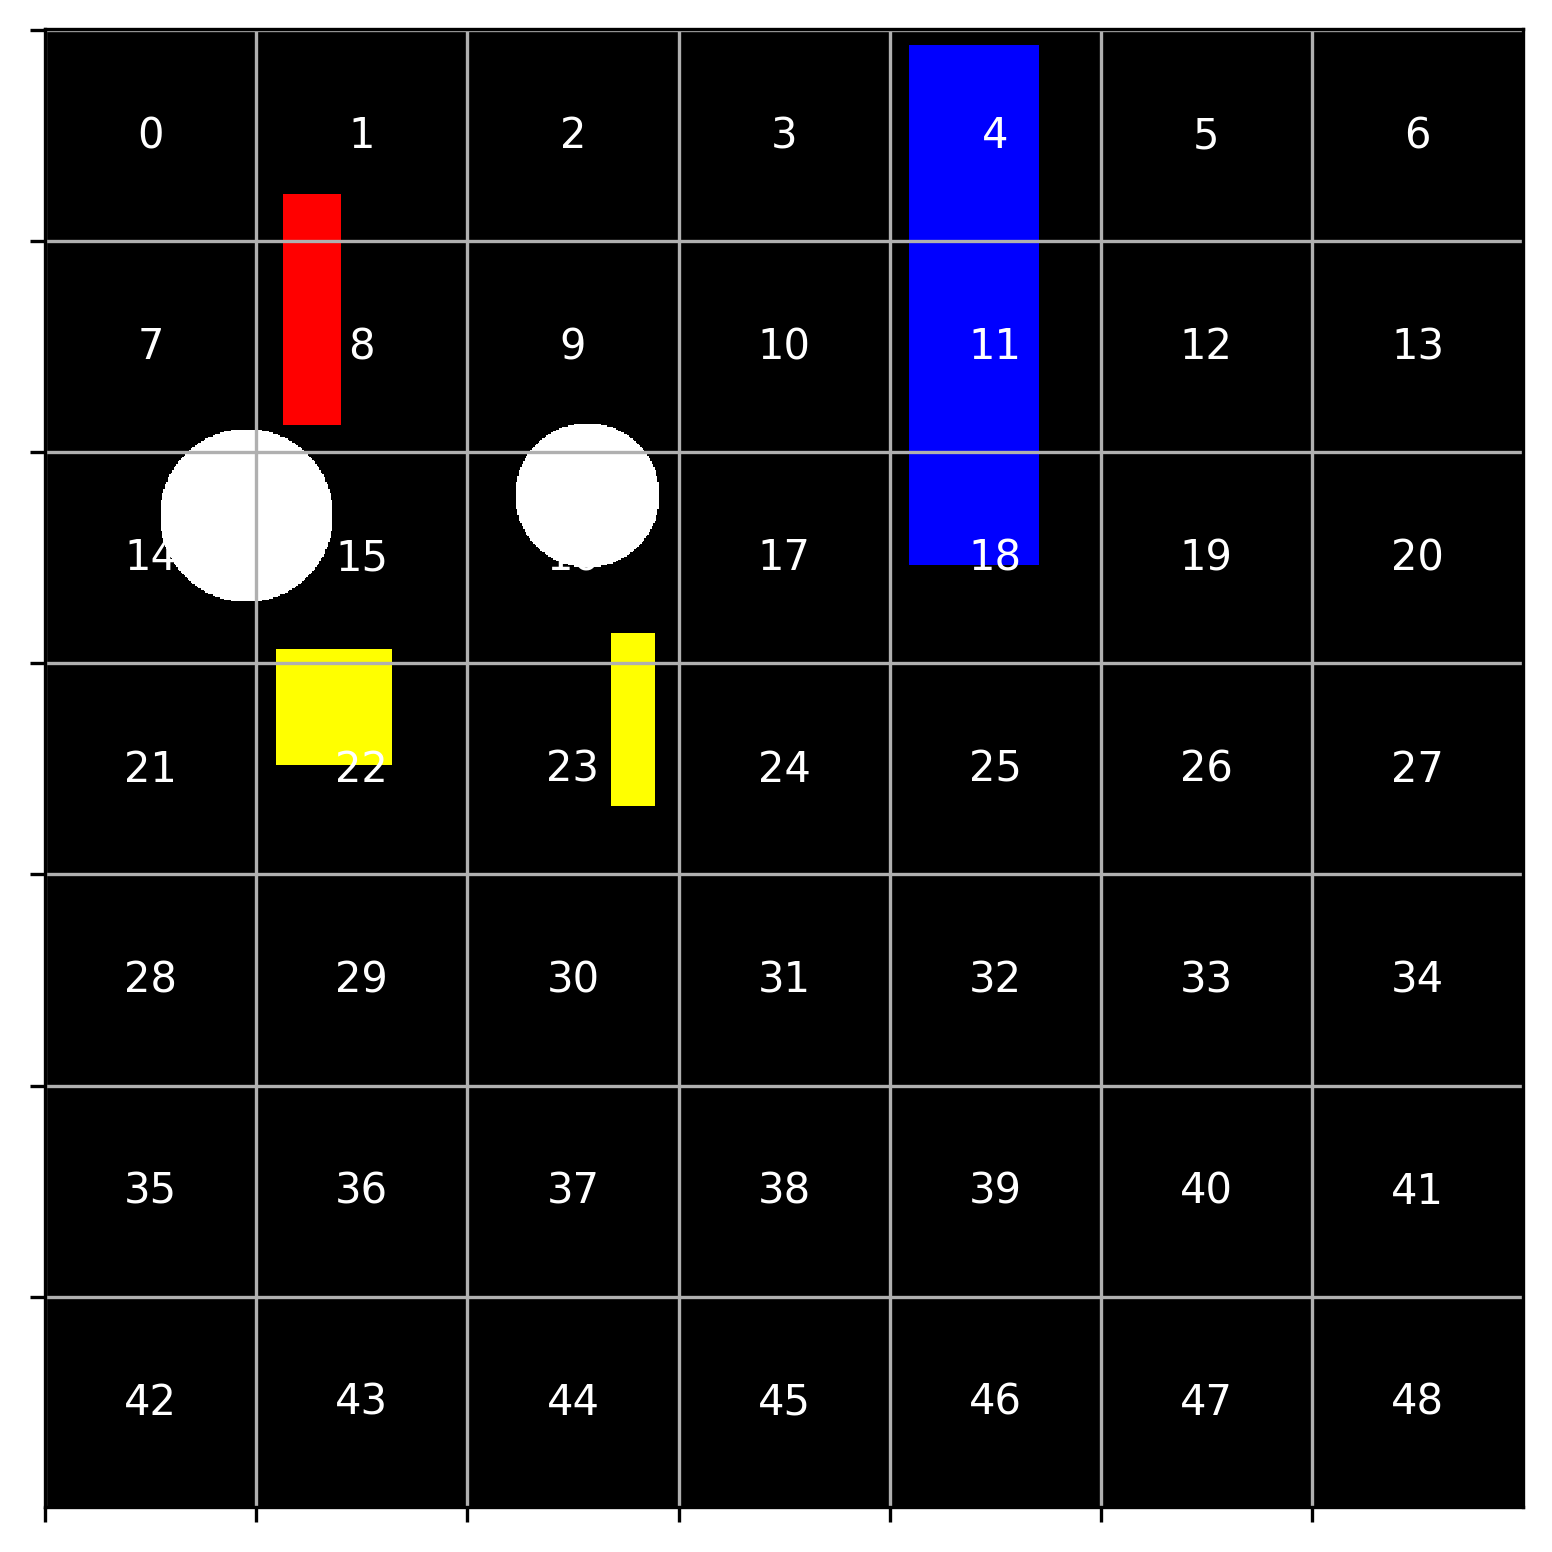

In [8]:
import transformer_patches
import counter

img_id = "6"
patches = transformer_patches.get_all_patches_with_objects(f'{img_id}.png', "pos", "train")
transformer_patches.open_image_withpatches(f"{img_id}.png", "pos", "train", to_save=False)

In [9]:
import transformer_patches

patches = transformer_patches.get_all_patches_with_objects(f"{img_id}.png", "pos", "train")

In [10]:
patches

defaultdict(<function transformer_patches.get_all_patches_with_objects.<locals>.<lambda>()>,
            {1: [{'rr': '195',
               'area': '6400',
               'cc': '185.0',
               'k': '0.159',
               'thresh_dist': '0.7438',
               'object_id': '5',
               'color': 'red',
               'shape': 'rectangle',
               'radius': '40',
               'vagueness': 'same',
               'prob': '1.0',
               'size': 'small',
               'rotation': 'vert',
               'box': [238, 165, 298, 399]}],
             4: [{'rr': '192',
               'area': '32400',
               'cc': '643.0',
               'k': '0.159',
               'thresh_dist': '0.159',
               'object_id': '2',
               'color': 'blue',
               'shape': 'rectangle',
               'radius': '90',
               'vagueness': 'same',
               'prob': '0.8201',
               'size': 'big',
               'rotation': 'vert',
       

In [11]:
object_ids = set()
for patch, boxes in patches.items():
    for box in boxes:
        object_ids.add(box['object_id'])

In [12]:
object_ids

{'0', '1', '2', '3', '4', '5'}

In [13]:
import bounding_boxes

boxes = bounding_boxes.get_boxes(f"{img_id}.png", "pos", "train")

In [14]:
boxes

[{'rr': '470',
  'area': '6400',
  'cc': '200',
  'k': '0.159',
  'thresh_dist': '0.7438',
  'object_id': '0',
  'color': 'yellow',
  'shape': 'square',
  'radius': '40',
  'vagueness': 'same',
  'prob': '1.0',
  'size': 'small',
  'rotation': 'N/A',
  'box': [231, 621, 347, 737]},
 {'rr': '479',
  'area': '3600',
  'cc': '407.0',
  'k': '0.159',
  'thresh_dist': '0.841',
  'object_id': '1',
  'color': 'yellow',
  'shape': 'rectangle',
  'radius': '30',
  'vagueness': 'same',
  'prob': '1.0',
  'size': 'small',
  'rotation': 'vert',
  'box': [565, 603, 611, 781]},
 {'rr': '192',
  'area': '32400',
  'cc': '643.0',
  'k': '0.159',
  'thresh_dist': '0.159',
  'object_id': '2',
  'color': 'blue',
  'shape': 'rectangle',
  'radius': '90',
  'vagueness': 'same',
  'prob': '0.8201',
  'size': 'big',
  'rotation': 'vert',
  'box': [863, 17, 995, 539]},
 {'rr': '323',
  'area': '7825',
  'cc': '375',
  'k': '0.159',
  'thresh_dist': '0.6943',
  'object_id': '3',
  'color': 'white',
  'shape': 

In [15]:
from collections import defaultdict
from PIL import Image

def get_patches_for_objects(img_filename, dataset, split):
    img_path = f"../data/{dataset}/images/{split}/{img_filename}"
    boxes = bounding_boxes.get_boxes(img_filename, dataset, split)

    img = Image.open(img_path)
    height, width = img.size
    step = int(height / 7)

    patches = defaultdict(lambda: [])
    for j, y in enumerate(range(0, step * 7, step)):
        for i, x in enumerate(range(0, step * 7, step)):
            number = i + j * 7
            patch = (x, y, x + int(width / 7), y + int(height / 7))
            for box in boxes:
                if transformer_patches.check_box_in_patch(patch, box):
                    patches[box['object_id']].append(number)
    return patches

In [16]:
patches = get_patches_for_objects(f"{img_id}.png", "pos", "train")

In [17]:
patches

defaultdict(<function __main__.get_patches_for_objects.<locals>.<lambda>()>,
            {'5': [1, 8],
             '2': [4, 11, 18],
             '4': [7, 8, 14, 15],
             '3': [9, 16],
             '0': [15, 22],
             '1': [16, 23]})

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

color_to_pltcolor = {
    'green': 'lime',
    'blue': 'blue',
    'red': 'red',
    'yellow': 'yellow',
    'white': 'white',
}

def show_patches(imgname, dataset, split, to_save=False):
    plt.rcParams['hatch.linewidth'] = 9
    print(f"../data/{dataset}/images/{split}/{imgname}")
    # print(f"../plots/bb_{dataset}_{split}_{imgname}")
    image = Image.open(
        f"../data/{dataset}/images/{split}/{imgname}"
        # f"../plots/bb_{dataset}_{split}_{imgname}"
        # f"../examples/{dataset}/30patchimages/{imgname}"
    )
    my_dpi = 300

    # Set up figure
    print(image.size)
    fig = plt.figure(
        figsize=(float(image.size[0]) / my_dpi, float(image.size[1]) / my_dpi),
        dpi=my_dpi,
    )
    ax = fig.add_subplot(111)

    # Remove whitespace from around the image
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    # Set the gridding interval: here we use the major tick interval
    myInterval = image.size[0] / 7
    loc = plticker.MultipleLocator(base=myInterval)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)

    # Add the grid
    ax.grid(which="major", axis="both", linestyle="-")

    # Add the image
    ax.imshow(image)

    # Find number of gridsquares in x and y direction
    nx = abs(int(float(ax.get_xlim()[1] - ax.get_xlim()[0]) / float(myInterval)))
    ny = abs(int(float(ax.get_ylim()[1] - ax.get_ylim()[0]) / float(myInterval)))

    # Add some labels to the gridsquares
    patch_locations = {}

    for j in range(ny):
        y = myInterval / 2 + j * myInterval
        for i in range(nx):
            x = myInterval / 2.0 + float(i) * myInterval
            ax.text(
                # x, y, "{:d}".format(i + j * nx + 1), color="w", ha="center", va="center"
                x,
                y,
                "{:d}".format(i + j * nx),
                color="w",
                ha="center",
                va="center",
            )
            patch_locations[i + j * nx] = (float(i) * myInterval, j * myInterval)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Change patches with an object
    # dict = get_patches_for_objects(imgname, dataset, split)
    # boxes = bounding_boxes.get_boxes(imgname, dataset, split)
    # for box_id, patches in dict.items():
    #     color = [box['color'] for box in boxes if box["object_id"] == box_id]
    #     print(color)
    #     for patch in patches:
    #         ax.add_patch(plt.Rectangle(
    #             xy=patch_locations[patch],
    #             width=myInterval,
    #             height=myInterval,
    #             fill=True,
    #             edgecolor='white',
    #             facecolor=color_to_pltcolor[color[0]],
    #             linewidth=1,
    #         ))

    patches = transformer_patches.get_all_patches_with_objects(imgname, dataset, split)
    for patch_id, boxes in patches.items():
        colors = [color_to_pltcolor[box['color']] for box in boxes]
        if len(colors) == 1:
            ax.add_patch(plt.Rectangle(
                xy=patch_locations[patch_id],
                width=myInterval,
                height=myInterval,
                fill=True,
                edgecolor='white',
                facecolor=colors[0],
                linewidth=1,
            ))
        elif len(colors) == 2:
            ax.add_patch(plt.Rectangle(
                xy=patch_locations[patch_id],
                width=myInterval,
                height=myInterval,
                fill=True,
                edgecolor=colors[0],
                facecolor=colors[1],
                hatch = '/',
                linewidth=1,
            ))
        elif len(colors) == 3:
            ax.add_patch(plt.Rectangle(
                xy=patch_locations[patch_id],
                width=myInterval,
                height=myInterval,
                fill=True,
                edgecolor=colors[0],
                facecolor=colors[1],
                hatch = '/',
                linewidth=1,
            ))
            ax.add_patch(plt.Rectangle(
                xy=patch_locations[patch_id],
                width=myInterval,
                height=myInterval,
                fill=False,
                edgecolor=colors[2],
                # facecolor=colors[1],
                hatch = "\\",
                linewidth=1,
            ))


    if to_save:
        plt.savefig(
            # f"../examples/{dataset}/patches_{imgname}",
            f"../plots/patches_bb_{dataset}_{split}_{imgname}",
            # f"../examples/{dataset}/30patchimages/patches_{imgname}",
            bbox_inches="tight",
            pad_inches=0,
        )

    # plt.show()

../data/pos/images/test/3.png
(1478, 1478)


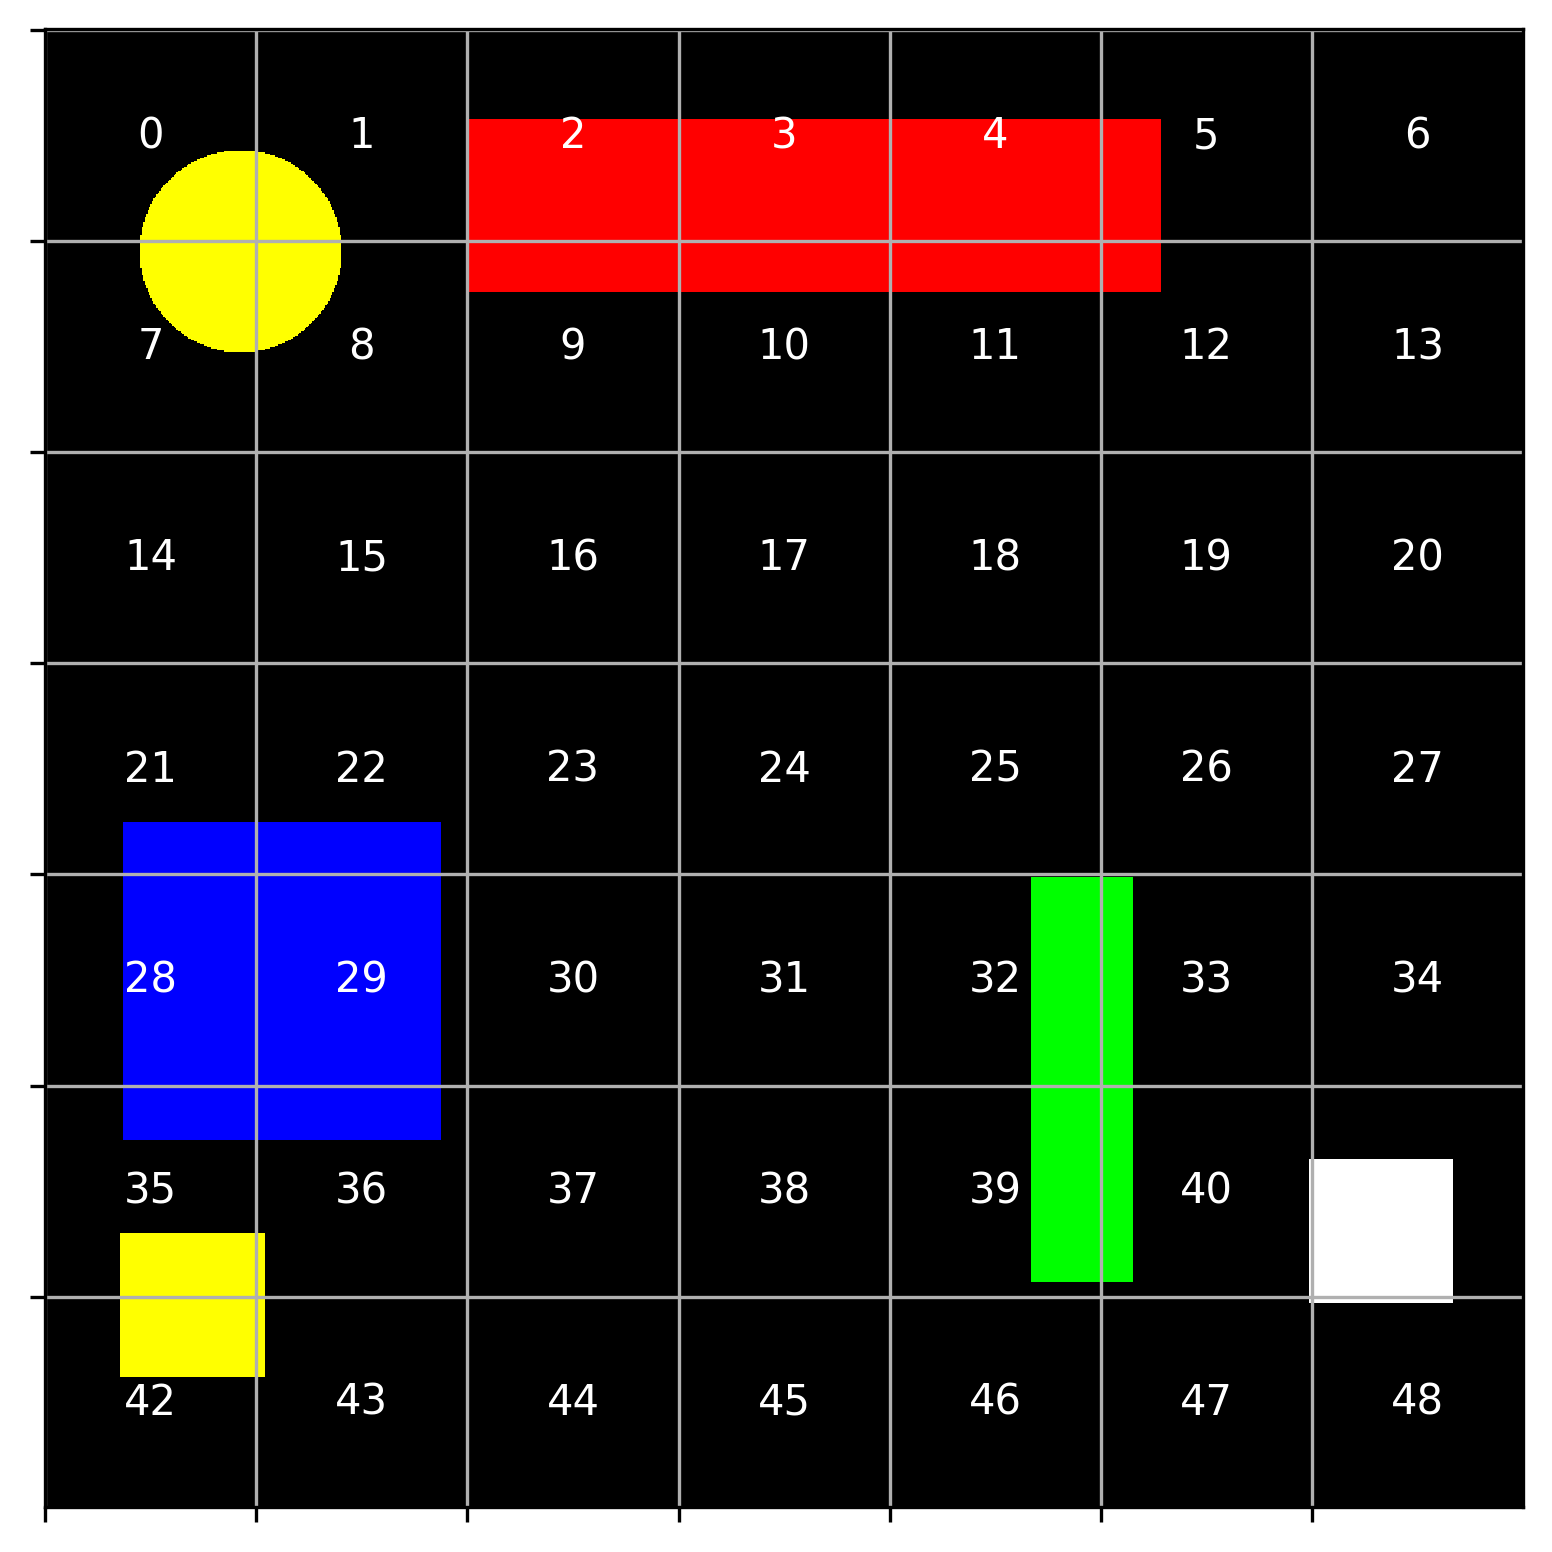

In [19]:
import transformer_patches
import counter

img_id = '3'
patches = transformer_patches.get_all_patches_with_objects(f'{img_id}.png', "pos", "test")
transformer_patches.open_image_withpatches(f"{img_id}.png", "pos", "test", to_save=False)

../data/pos/images/test/3.png
(1478, 1478)


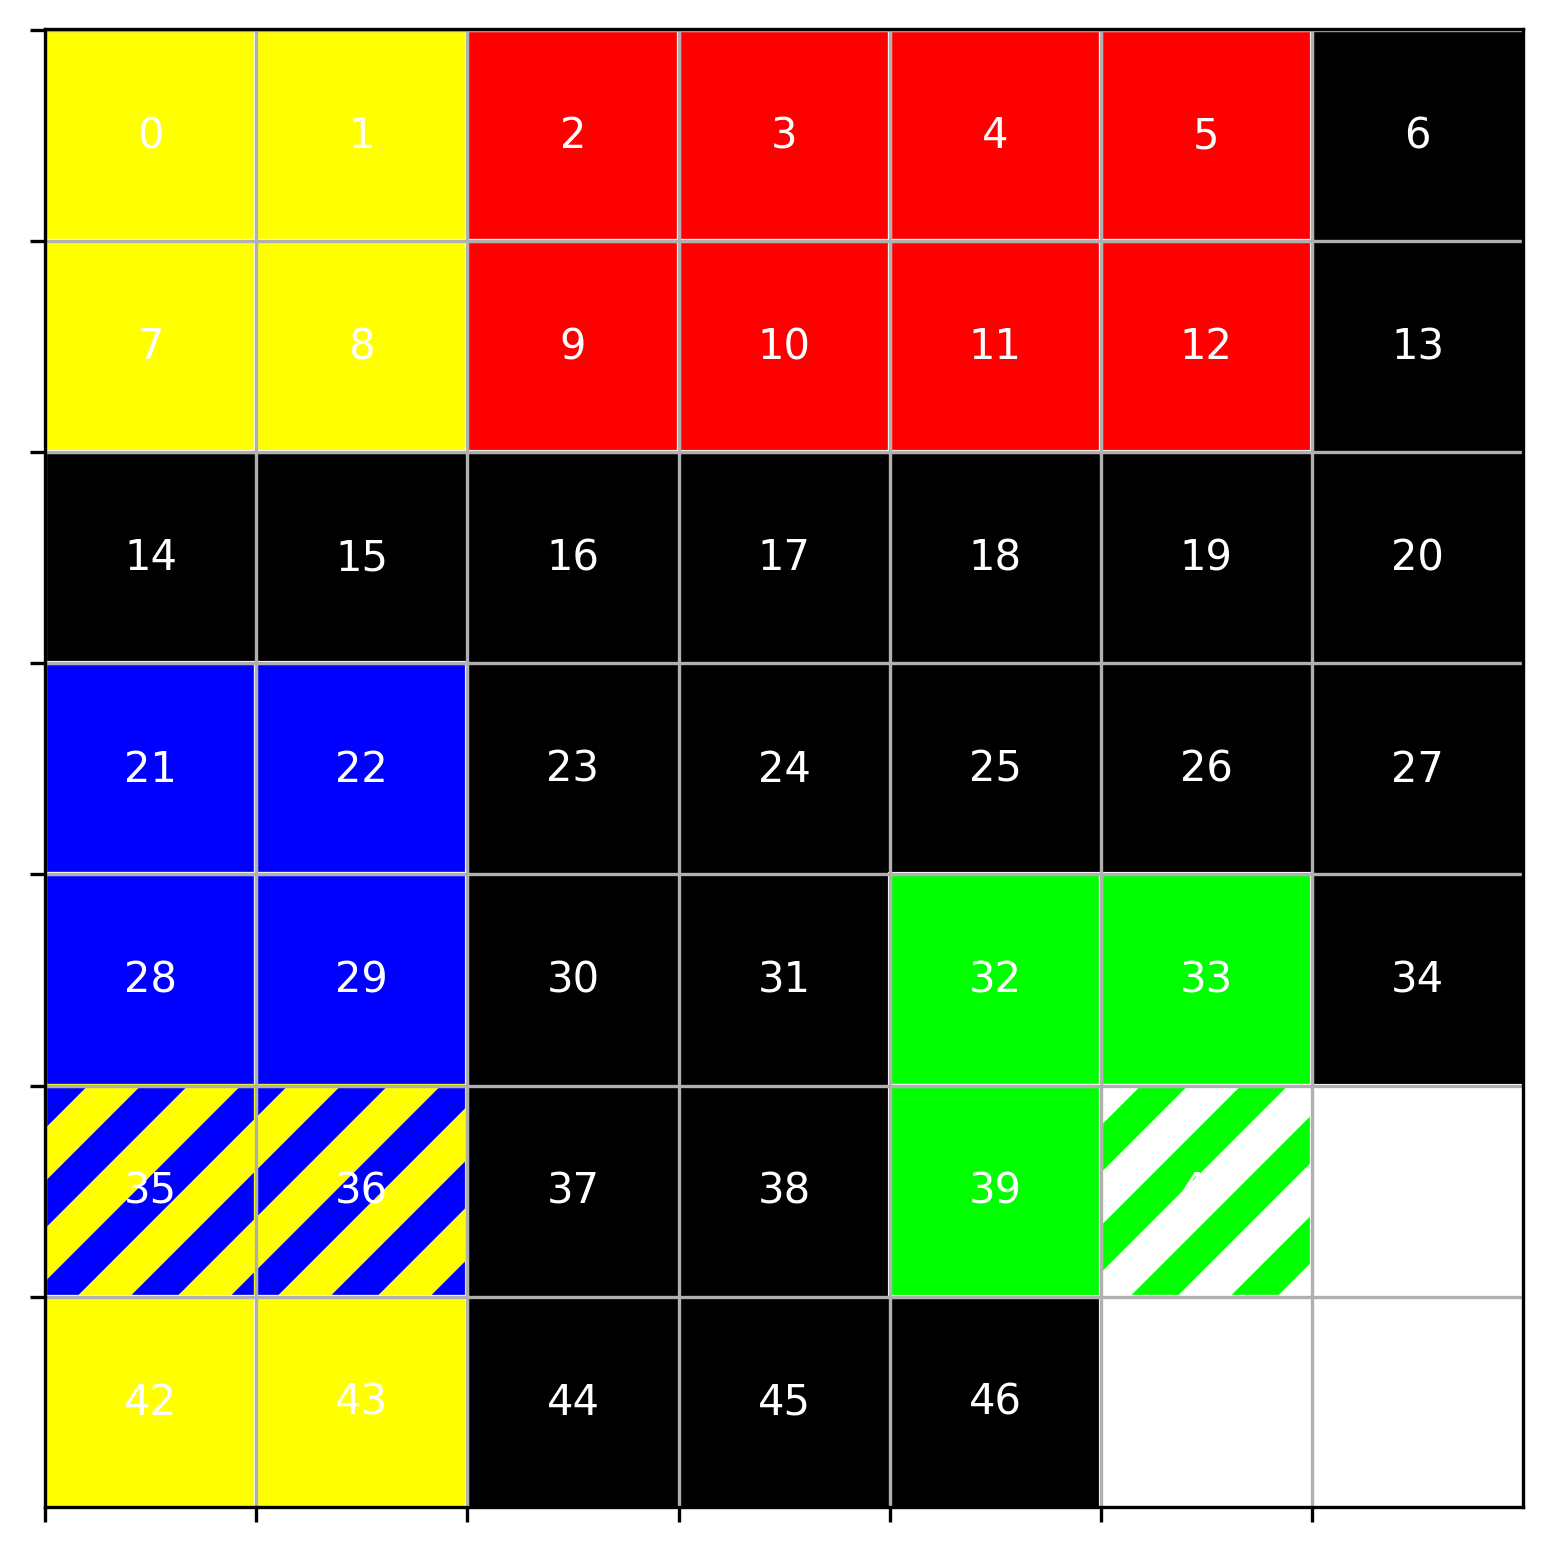

In [20]:
show_patches(f"{img_id}.png", "pos", "test", to_save=False)

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

color_to_pltcolor = {
    'green': 'lime',
    'blue': 'blue',
    'red': 'red',
    'yellow': 'yellow',
    'white': 'white',
}

def show_objectsets(imgname, dataset, split, object_sets, index, to_save=False):
    plt.rcParams['hatch.linewidth'] = 3
    # print(f"../data/{dataset}/images/{split}/{imgname}")
    # print(f"../plots/bb_{dataset}_{split}_{imgname}")
    image = Image.open(
        f"../data/{dataset}/images/{split}/{imgname}"
        # f"../../../images/natural_image_nobg_edits (1).png"
        # f"../plots/bb_{dataset}_{split}_{imgname}"
        # f"../examples/{dataset}/30patchimages/{imgname}"
    )
    my_dpi = 300

    # Set up figure
    print(image.size)
    fig = plt.figure(
        figsize=(float(image.size[0]) / my_dpi, float(image.size[1]) / my_dpi),
        dpi=my_dpi,
    )
    ax = fig.add_subplot(111)

    # Remove whitespace from around the image
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    # Set the gridding interval: here we use the major tick interval
    myInterval = image.size[0] / 7
    loc = plticker.MultipleLocator(base=myInterval)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)

    # Add the grid
    ax.grid(which="major", axis="both", linestyle="-")

    # Add the image
    ax.imshow(image)

    # Find number of gridsquares in x and y direction
    nx = abs(int(float(ax.get_xlim()[1] - ax.get_xlim()[0]) / float(myInterval)))
    ny = abs(int(float(ax.get_ylim()[1] - ax.get_ylim()[0]) / float(myInterval)))

    # Add some labels to the gridsquares
    patch_locations = {}

    for j in range(ny):
        y = myInterval / 2 + j * myInterval
        for i in range(nx):
            x = myInterval / 2.0 + float(i) * myInterval
            ax.text(
                # x, y, "{:d}".format(i + j * nx + 1), color="w", ha="center", va="center"
                x,
                y,
                "{:d}".format(i + j * nx),
                color="w",
                ha="center",
                va="center",
                fontsize="xx-small"
            )
            patch_locations[i + j * nx] = (float(i) * myInterval, j * myInterval)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

    patch_dict = defaultdict(lambda: [])
    for object_id, object_set in enumerate(object_sets):
        object_set = list(object_set)
        for patch_id in object_set:
            patch_dict[patch_id].append(object_id+1)

    for patch_id, boxes in patch_dict.items():
        colors = [box/len(object_sets) for box in boxes]
        if len(colors) == 1:
            ax.add_patch(plt.Rectangle(
                xy=patch_locations[patch_id],
                width=myInterval,
                height=myInterval,
                fill=True,
                edgecolor='white',
                facecolor=str(colors[0]),
                linewidth=1,
            ))
        elif len(colors) == 2:
            ax.add_patch(plt.Rectangle(
                xy=patch_locations[patch_id],
                width=myInterval,
                height=myInterval,
                fill=True,
                edgecolor=str(colors[0]),
                facecolor=str(colors[1]),
                hatch = '/',
                linewidth=1,
            ))
        elif len(colors) == 3:
            ax.add_patch(plt.Rectangle(
                xy=patch_locations[patch_id],
                width=myInterval,
                height=myInterval,
                fill=True,
                edgecolor=str(colors[0]),
                facecolor=str(colors[1]),
                hatch = '/',
                linewidth=1,
            ))
            ax.add_patch(plt.Rectangle(
                xy=patch_locations[patch_id],
                width=myInterval,
                height=myInterval,
                fill=False,
                edgecolor=str(colors[2]),
                # facecolor=colors[1],
                hatch = "\\",
                linewidth=1,
            ))


    if to_save:
        plt.savefig(
            # f"../examples/{dataset}/patches_{imgname}",
            f"../plots/patches_bb_{index}_{dataset}_{split}_{imgname}",
            # f"../examples/{dataset}/30patchimages/patches_{imgname}",
            bbox_inches="tight",
            pad_inches=0,
        )

    # plt.show()

(1478, 1478)
(1478, 1478)
(1478, 1478)
(1478, 1478)
(1478, 1478)
(1478, 1478)
(1478, 1478)
(1478, 1478)
(1478, 1478)
(1478, 1478)


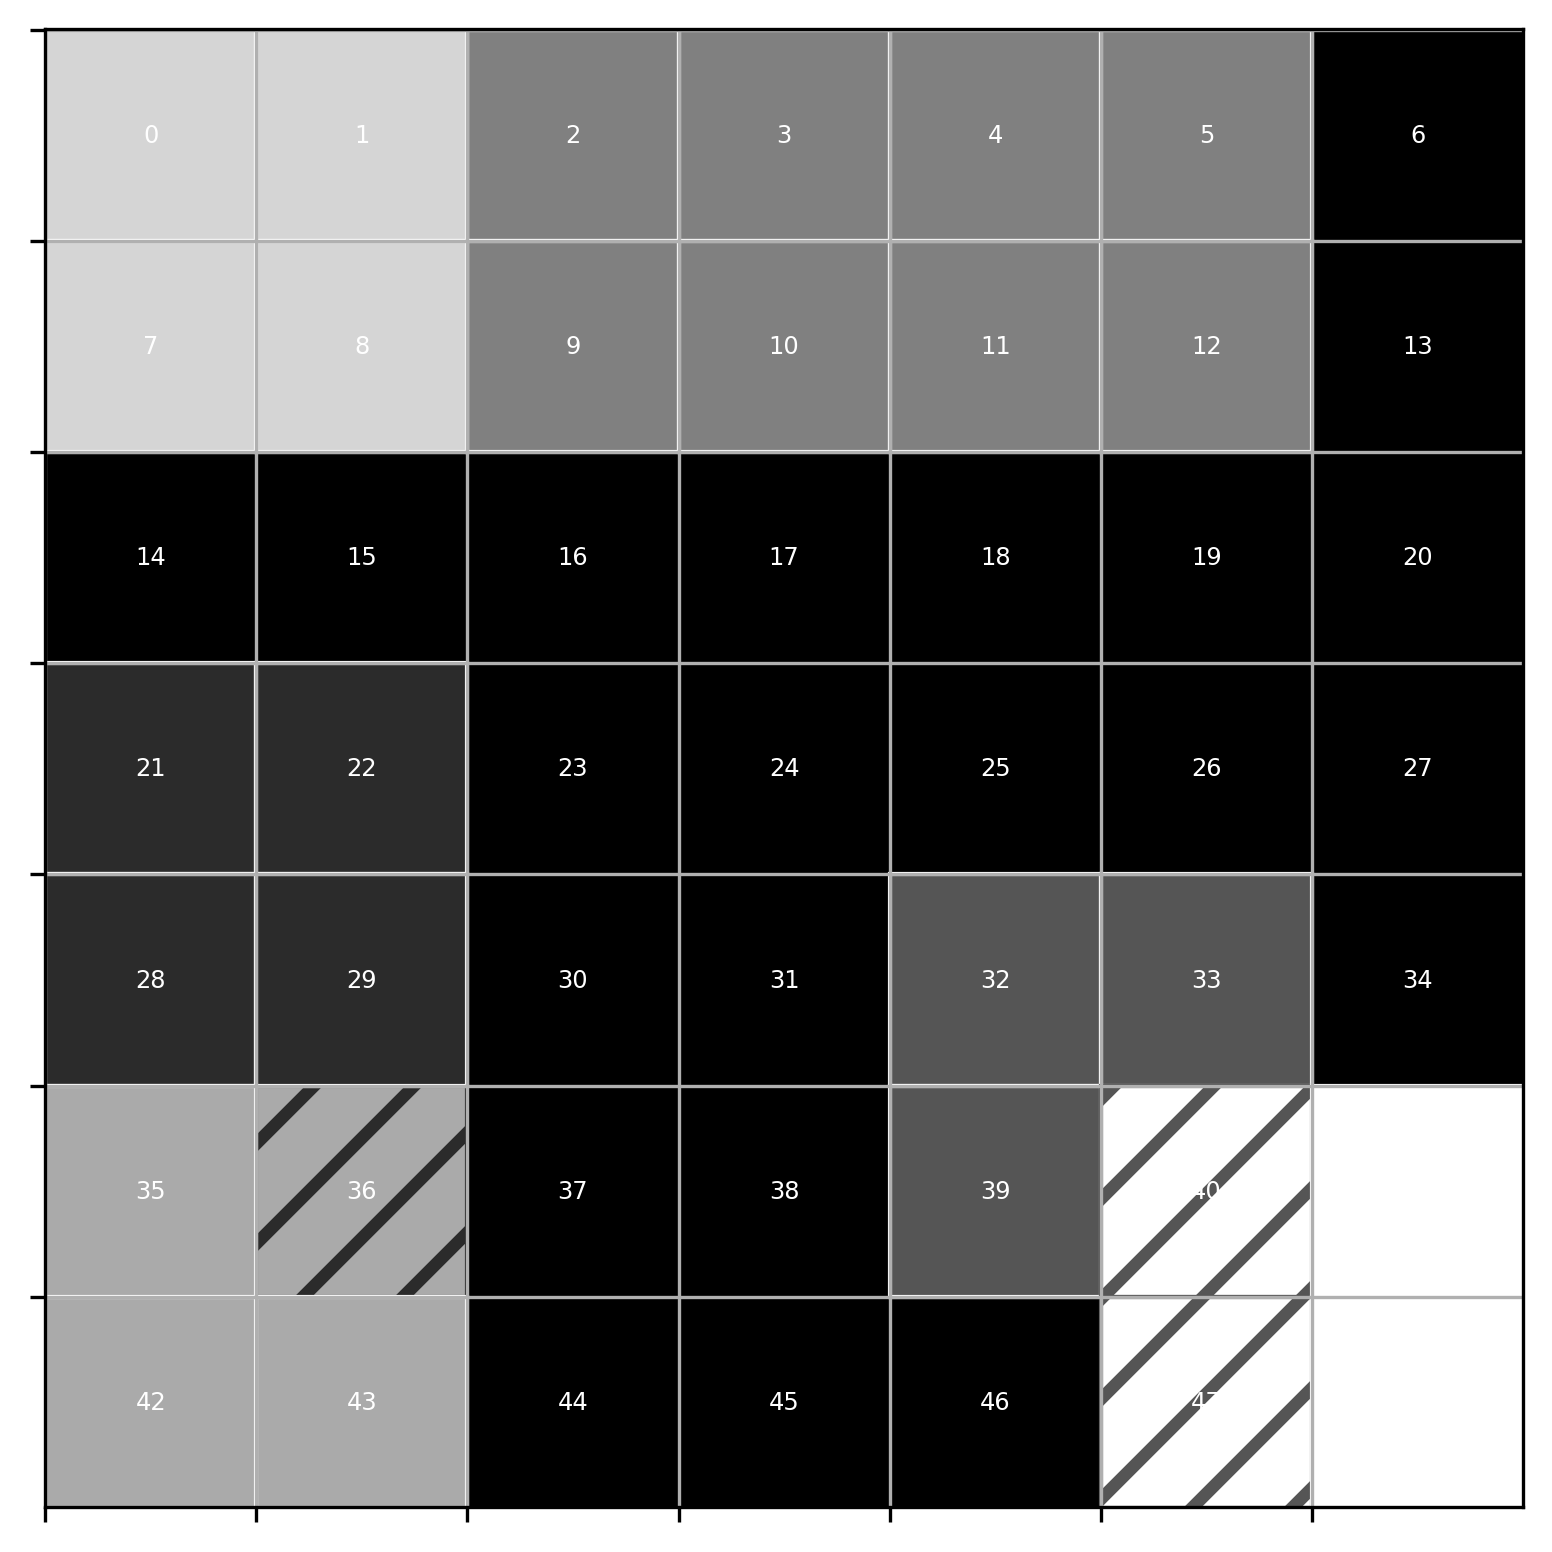

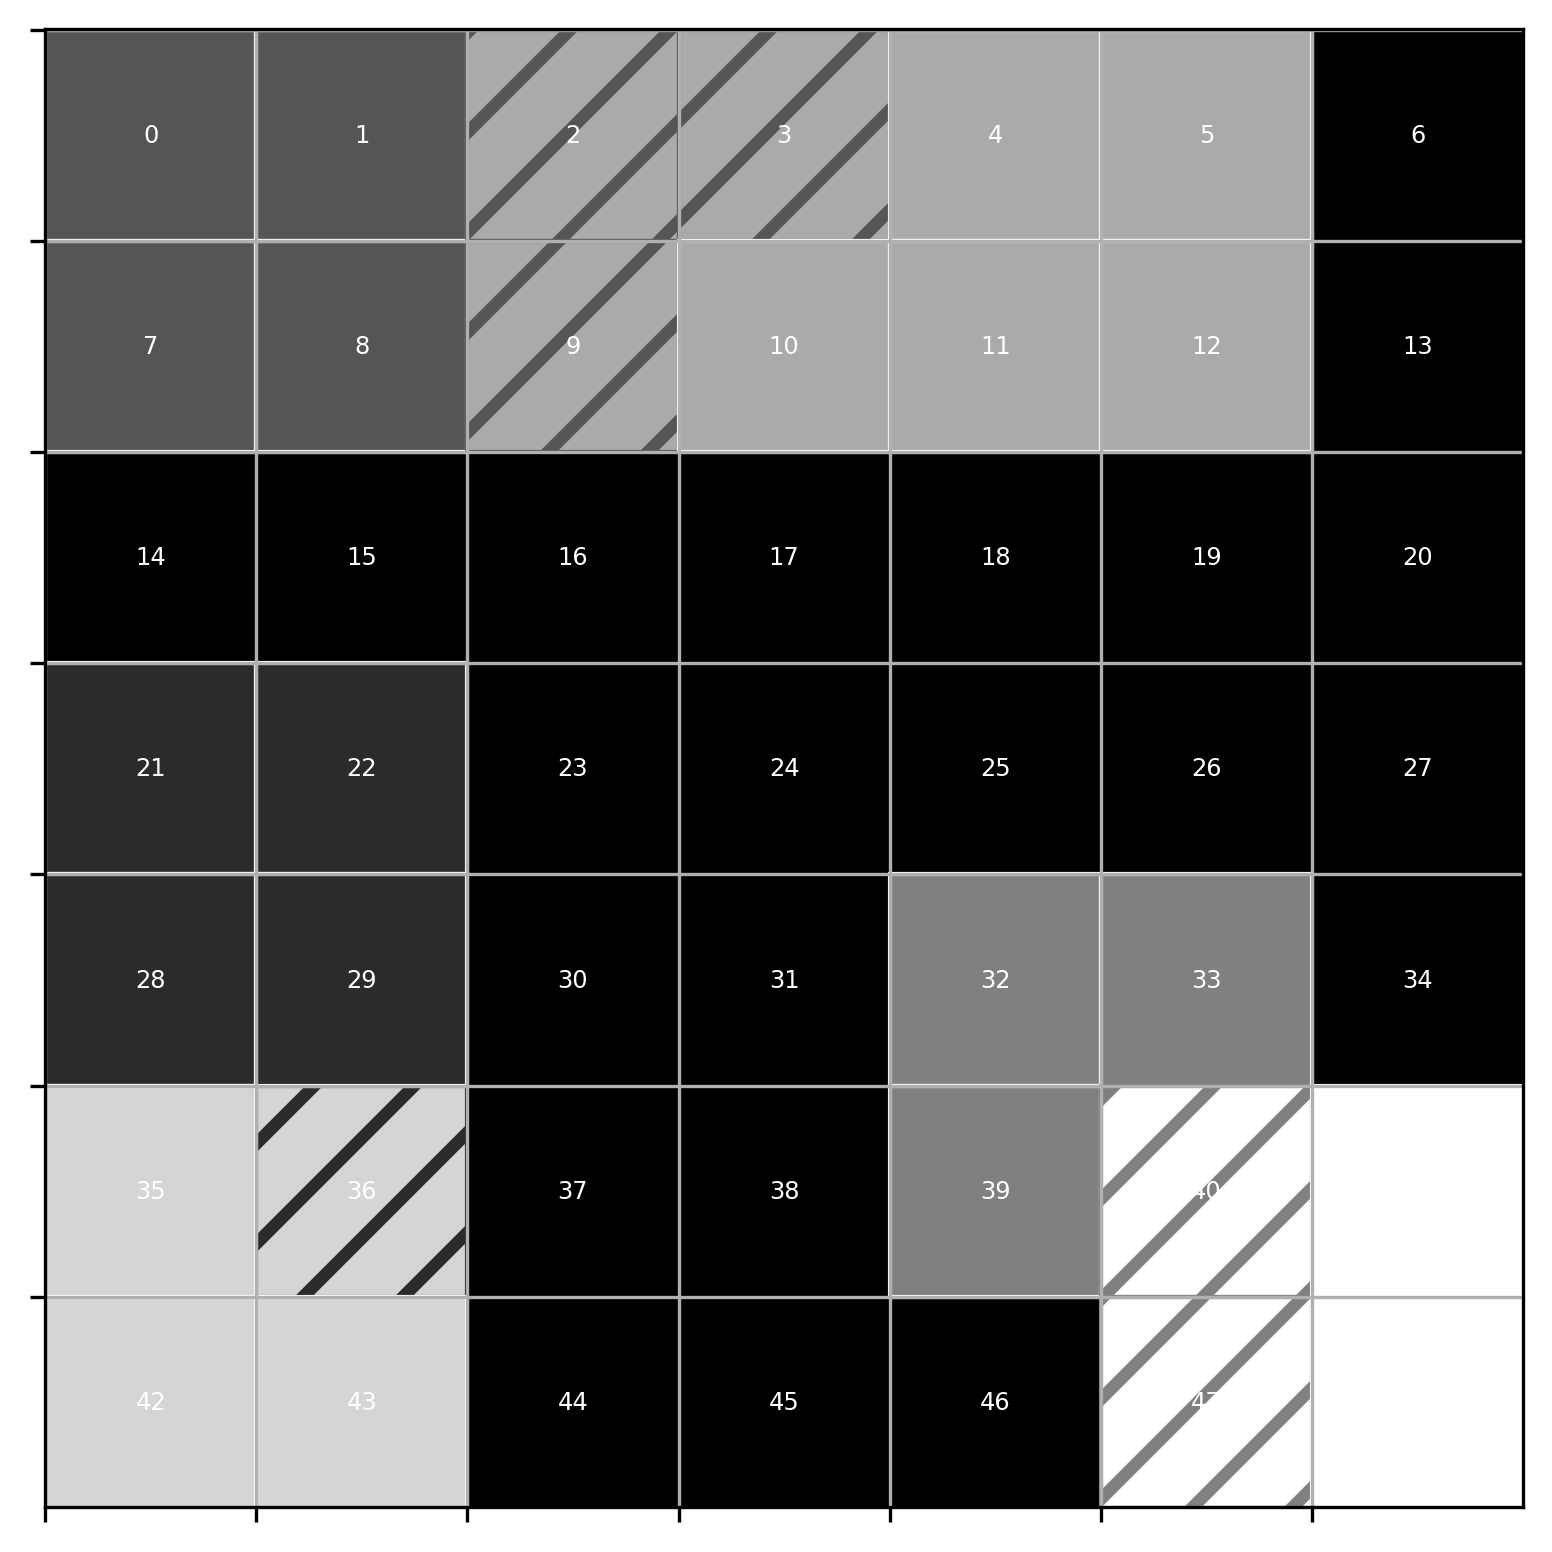

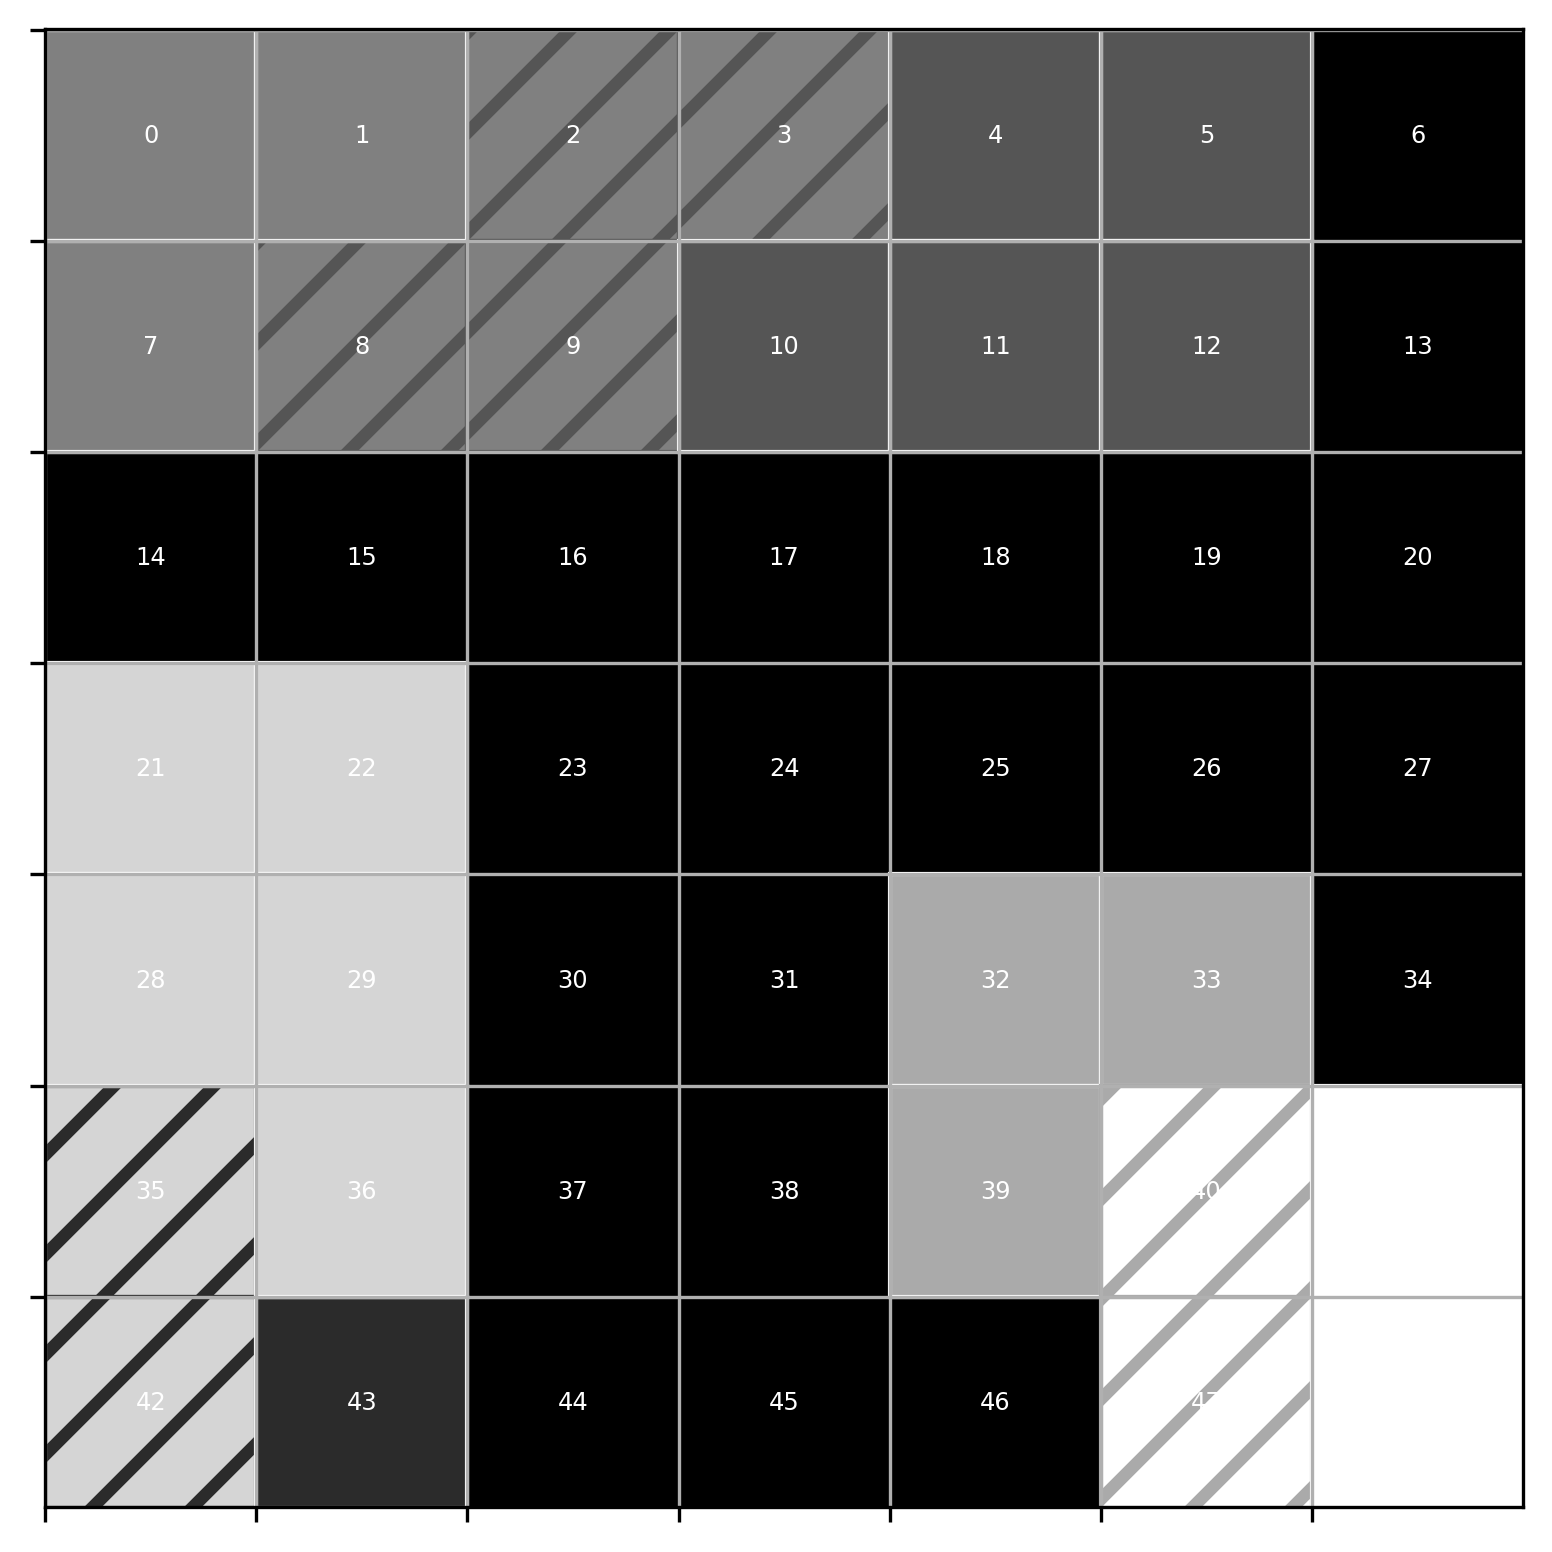

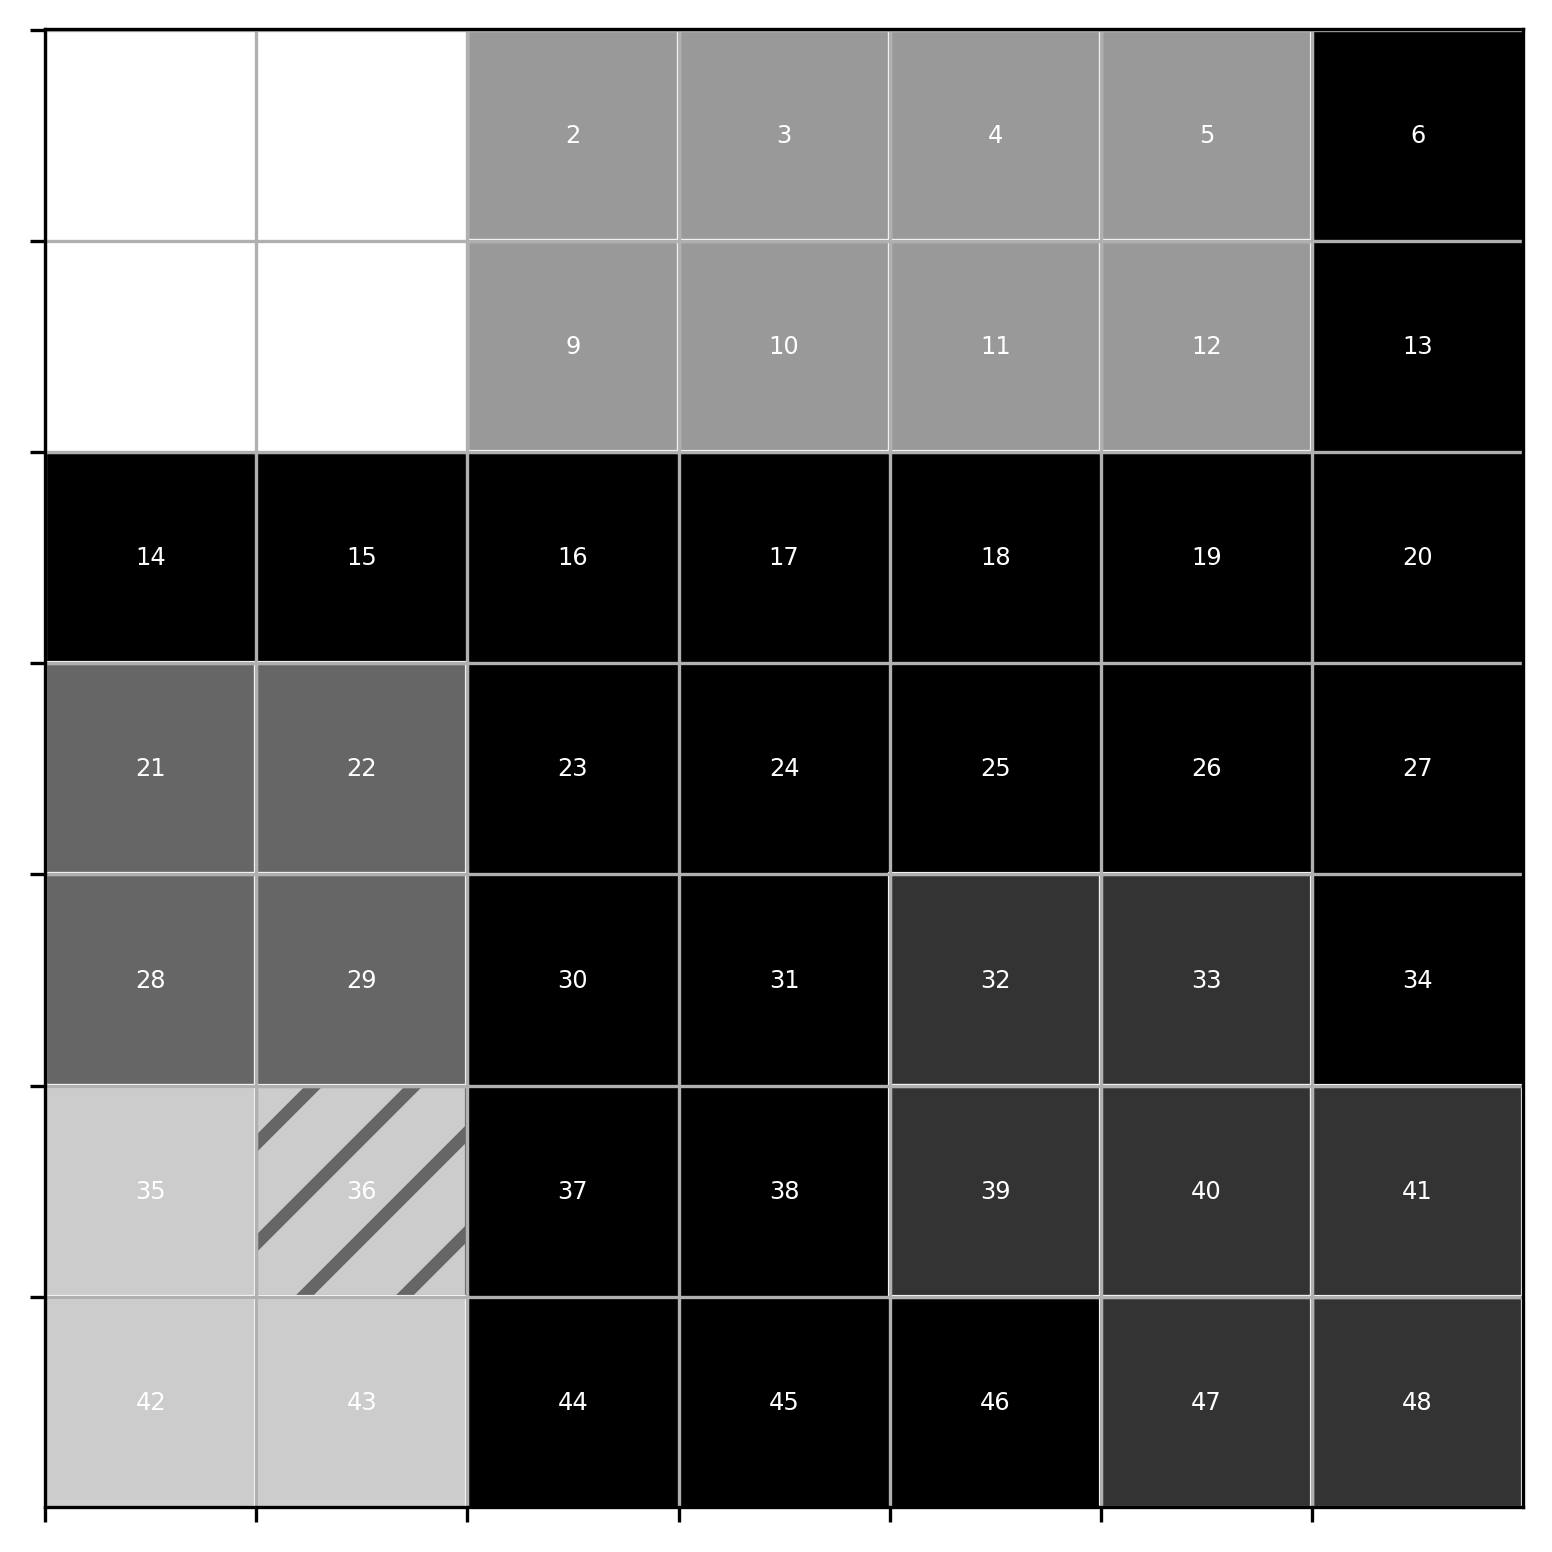

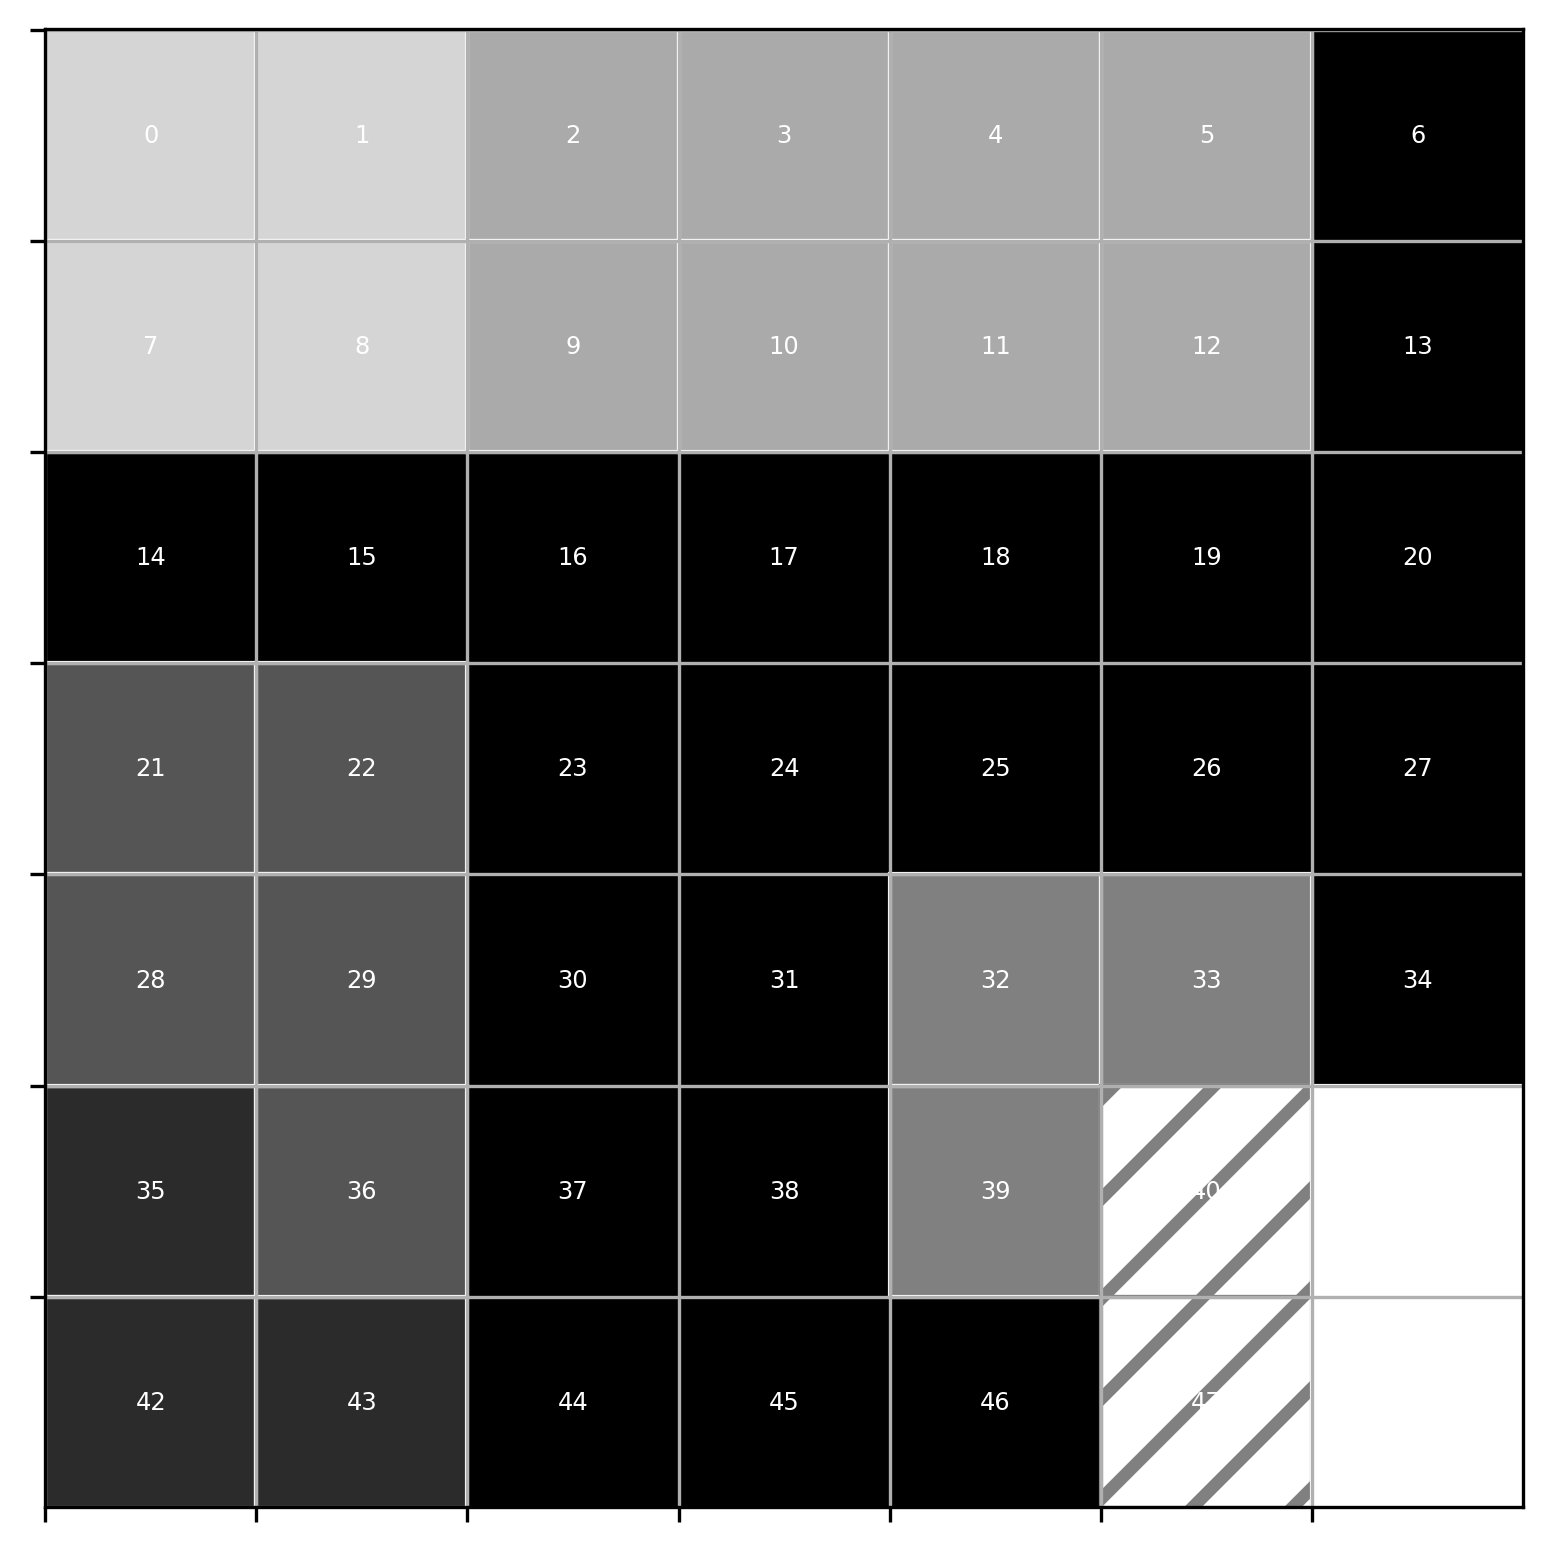

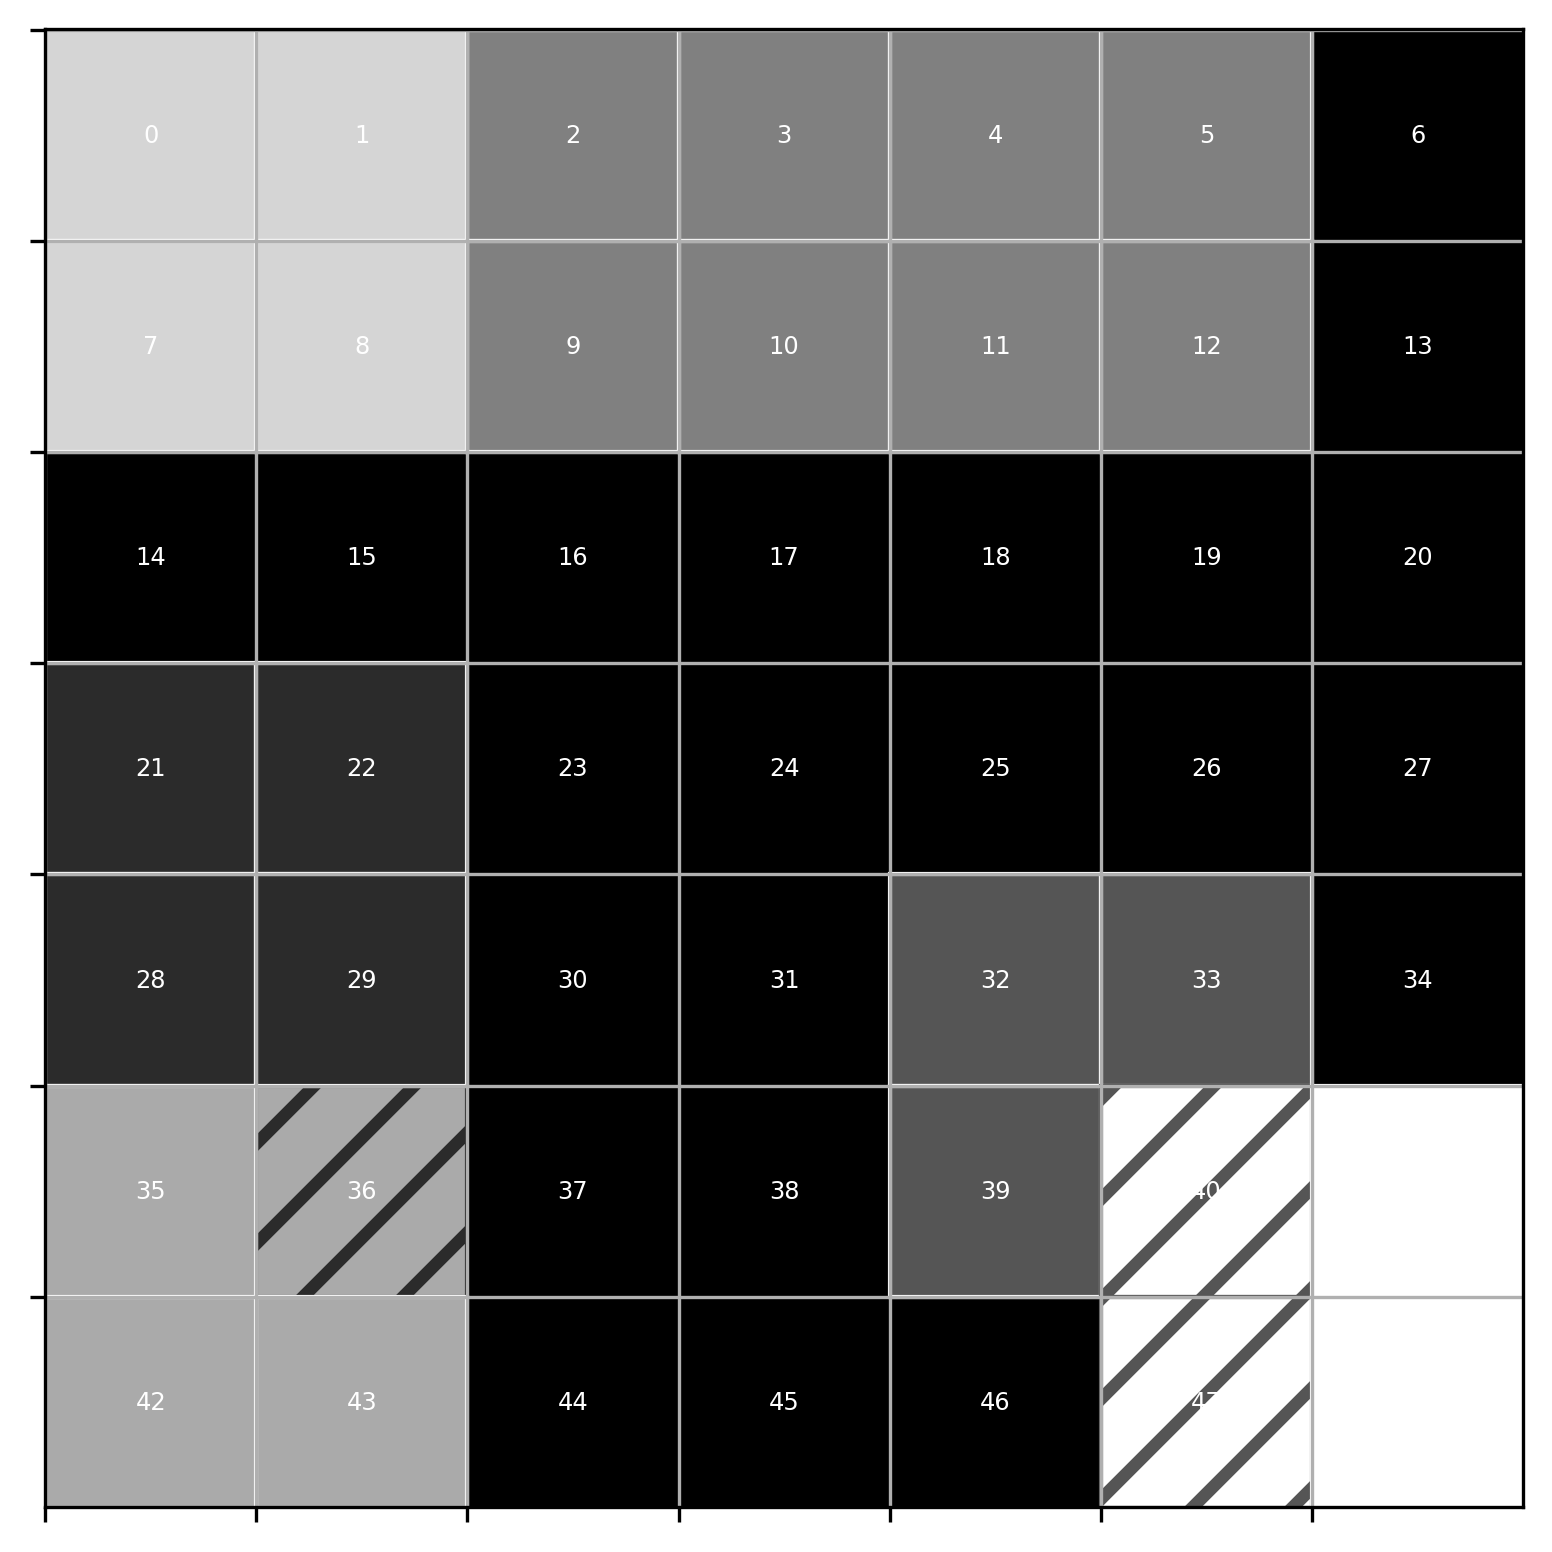

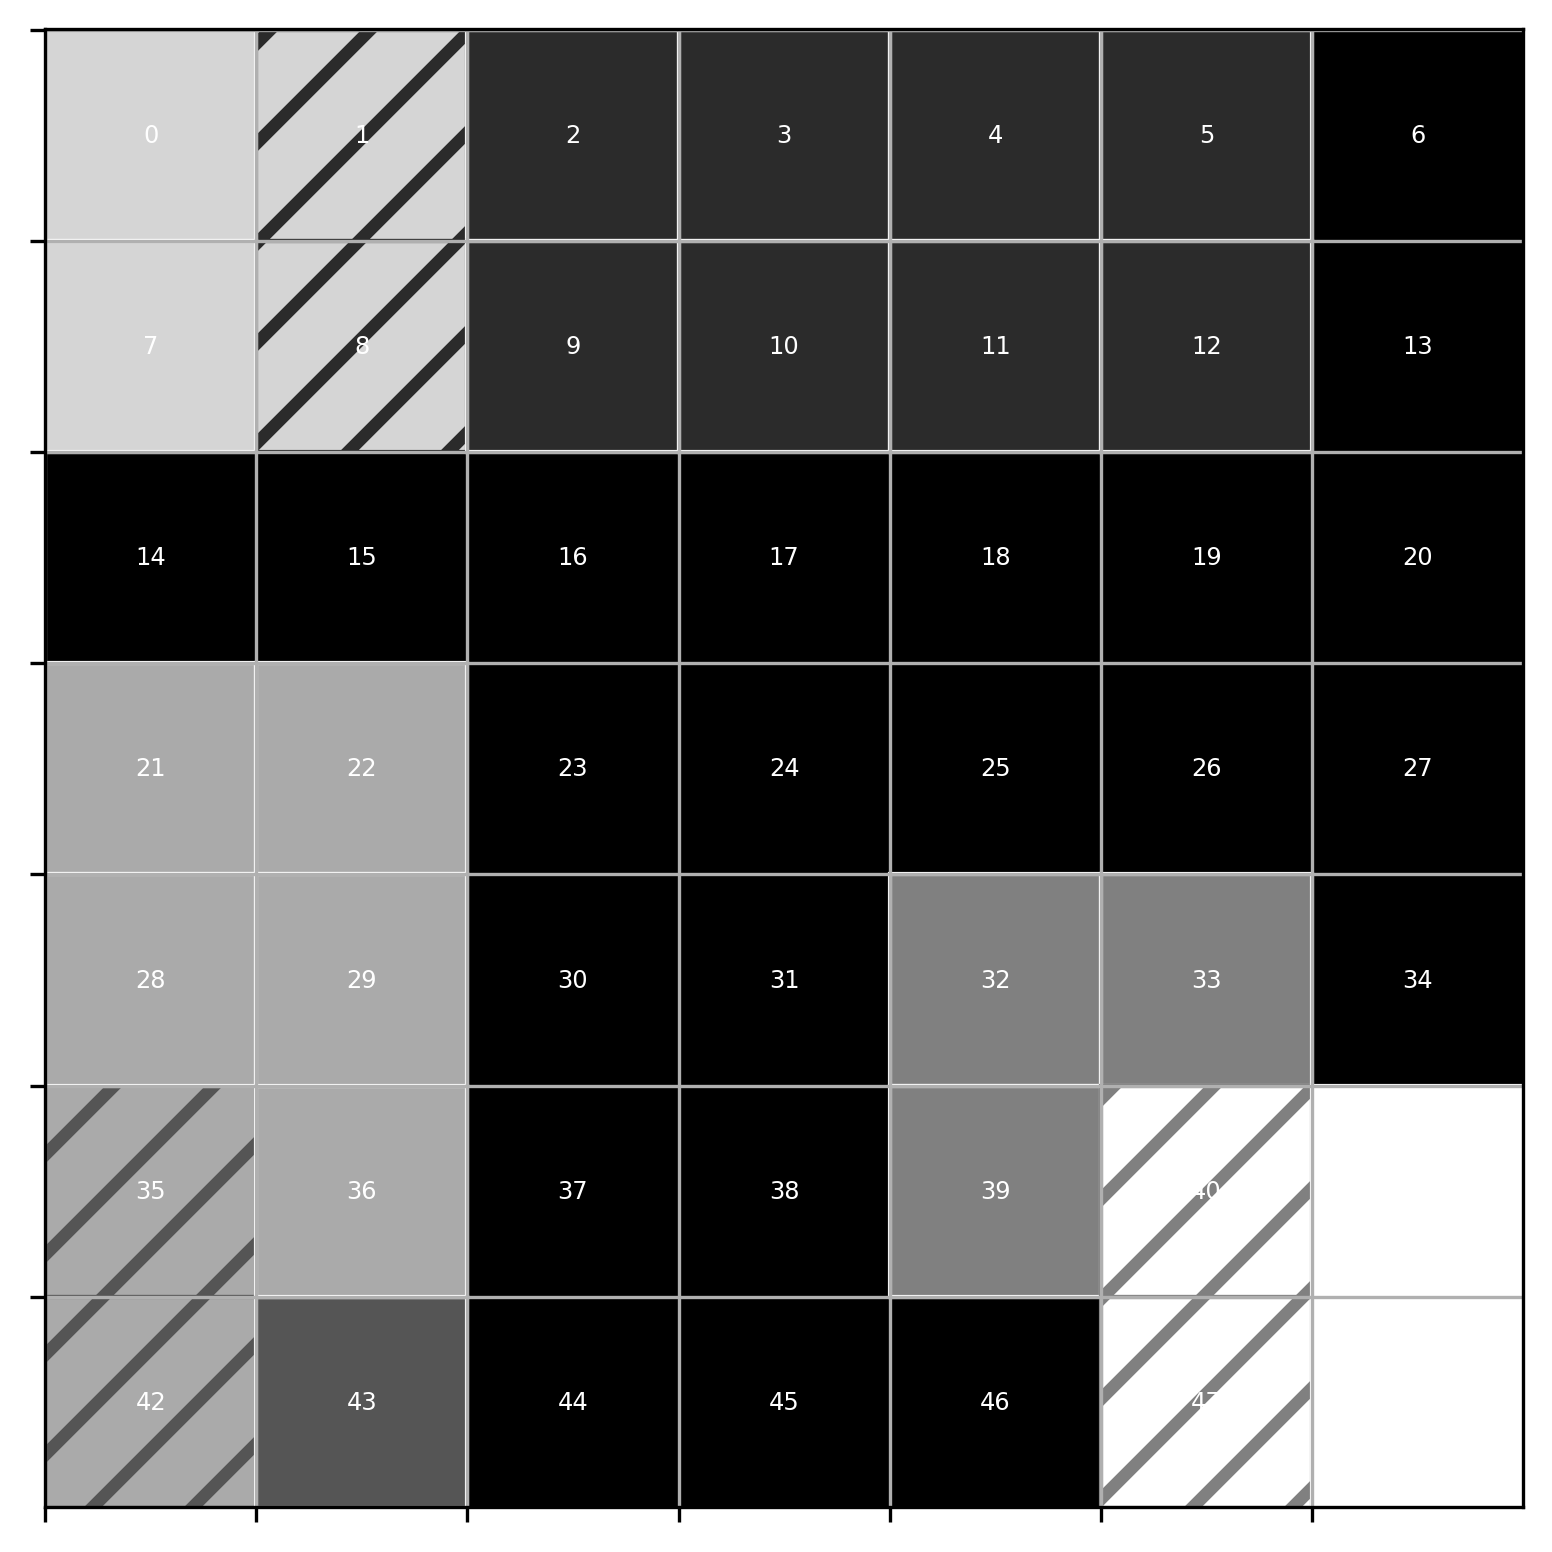

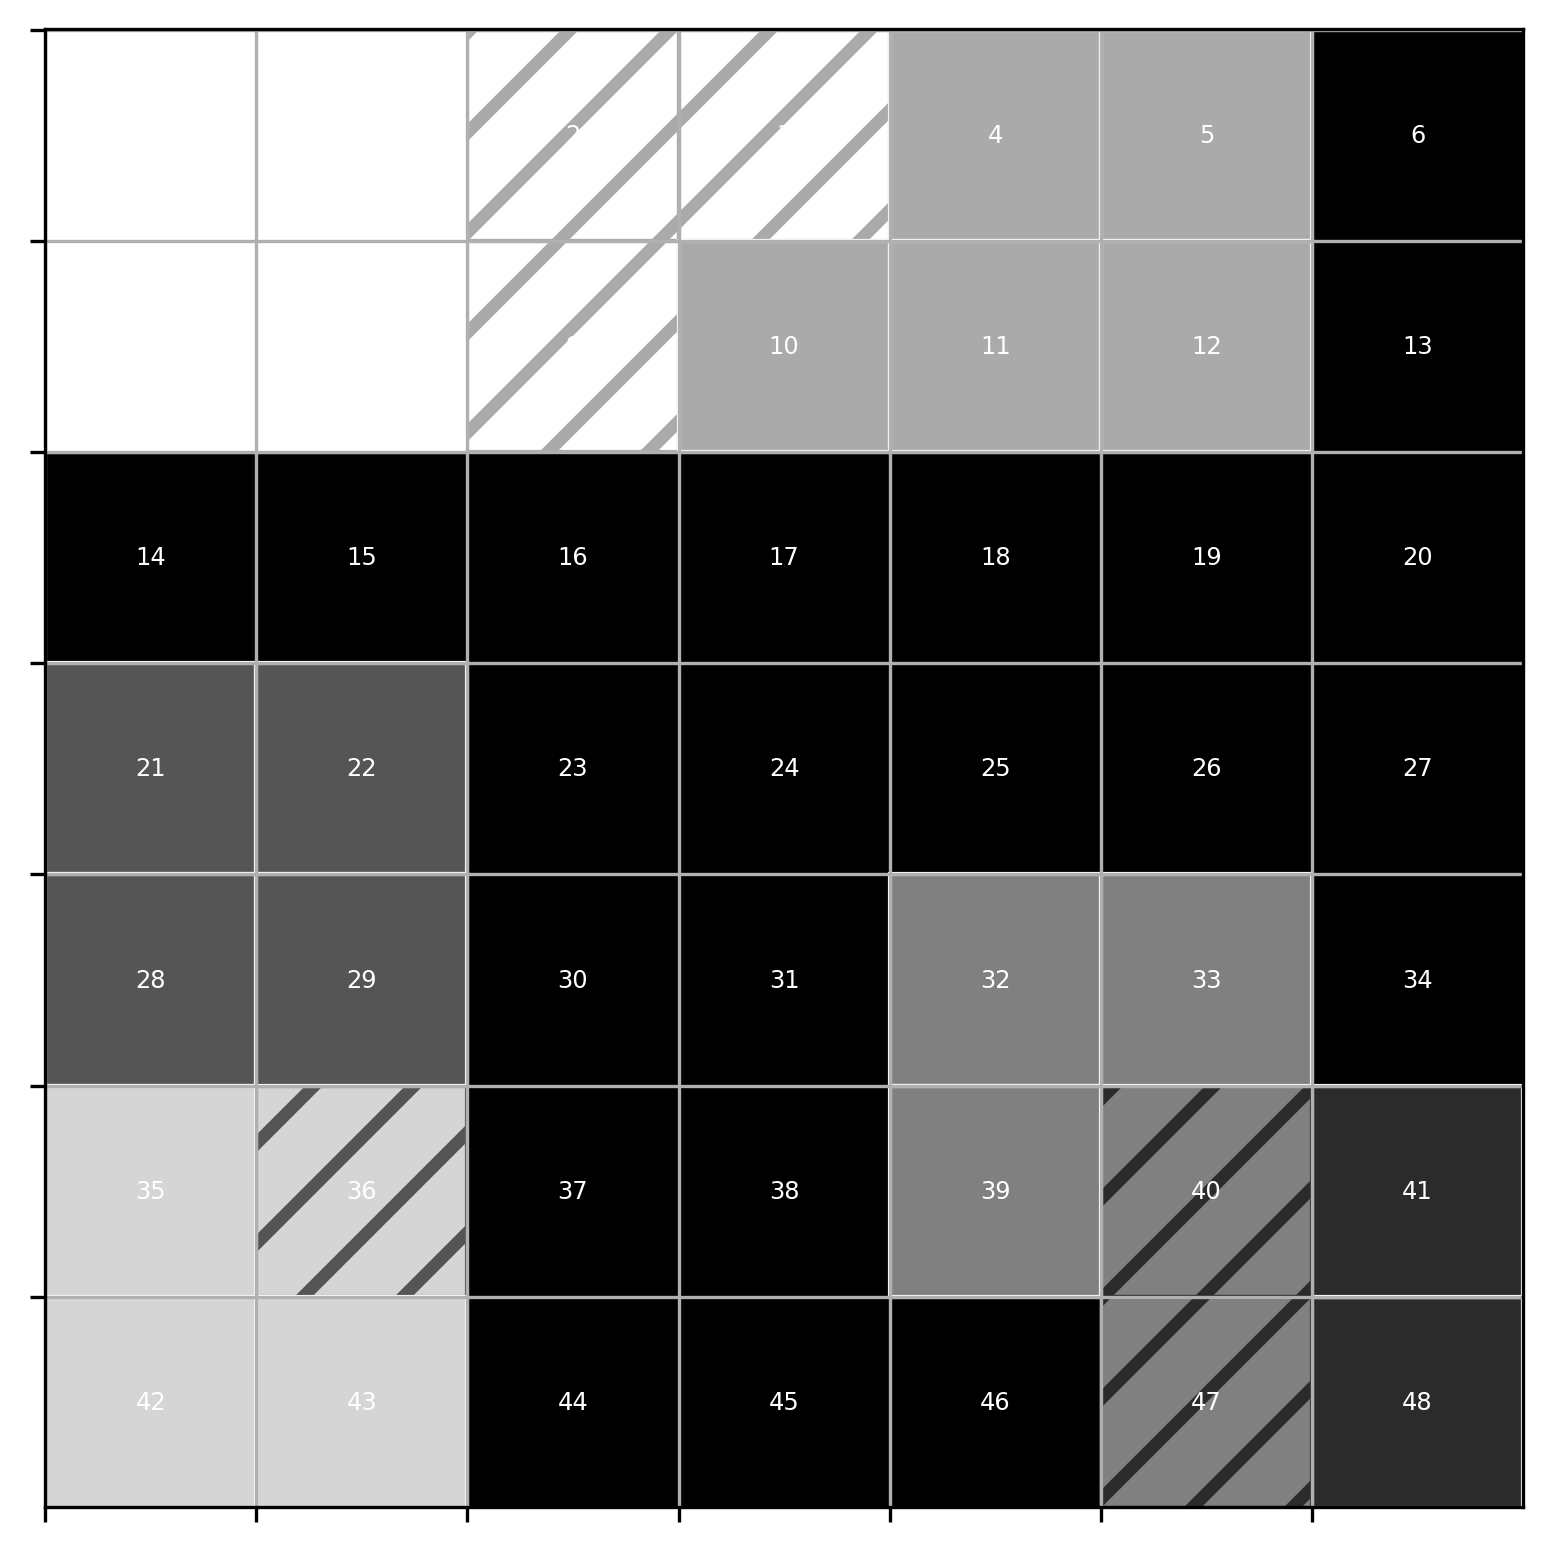

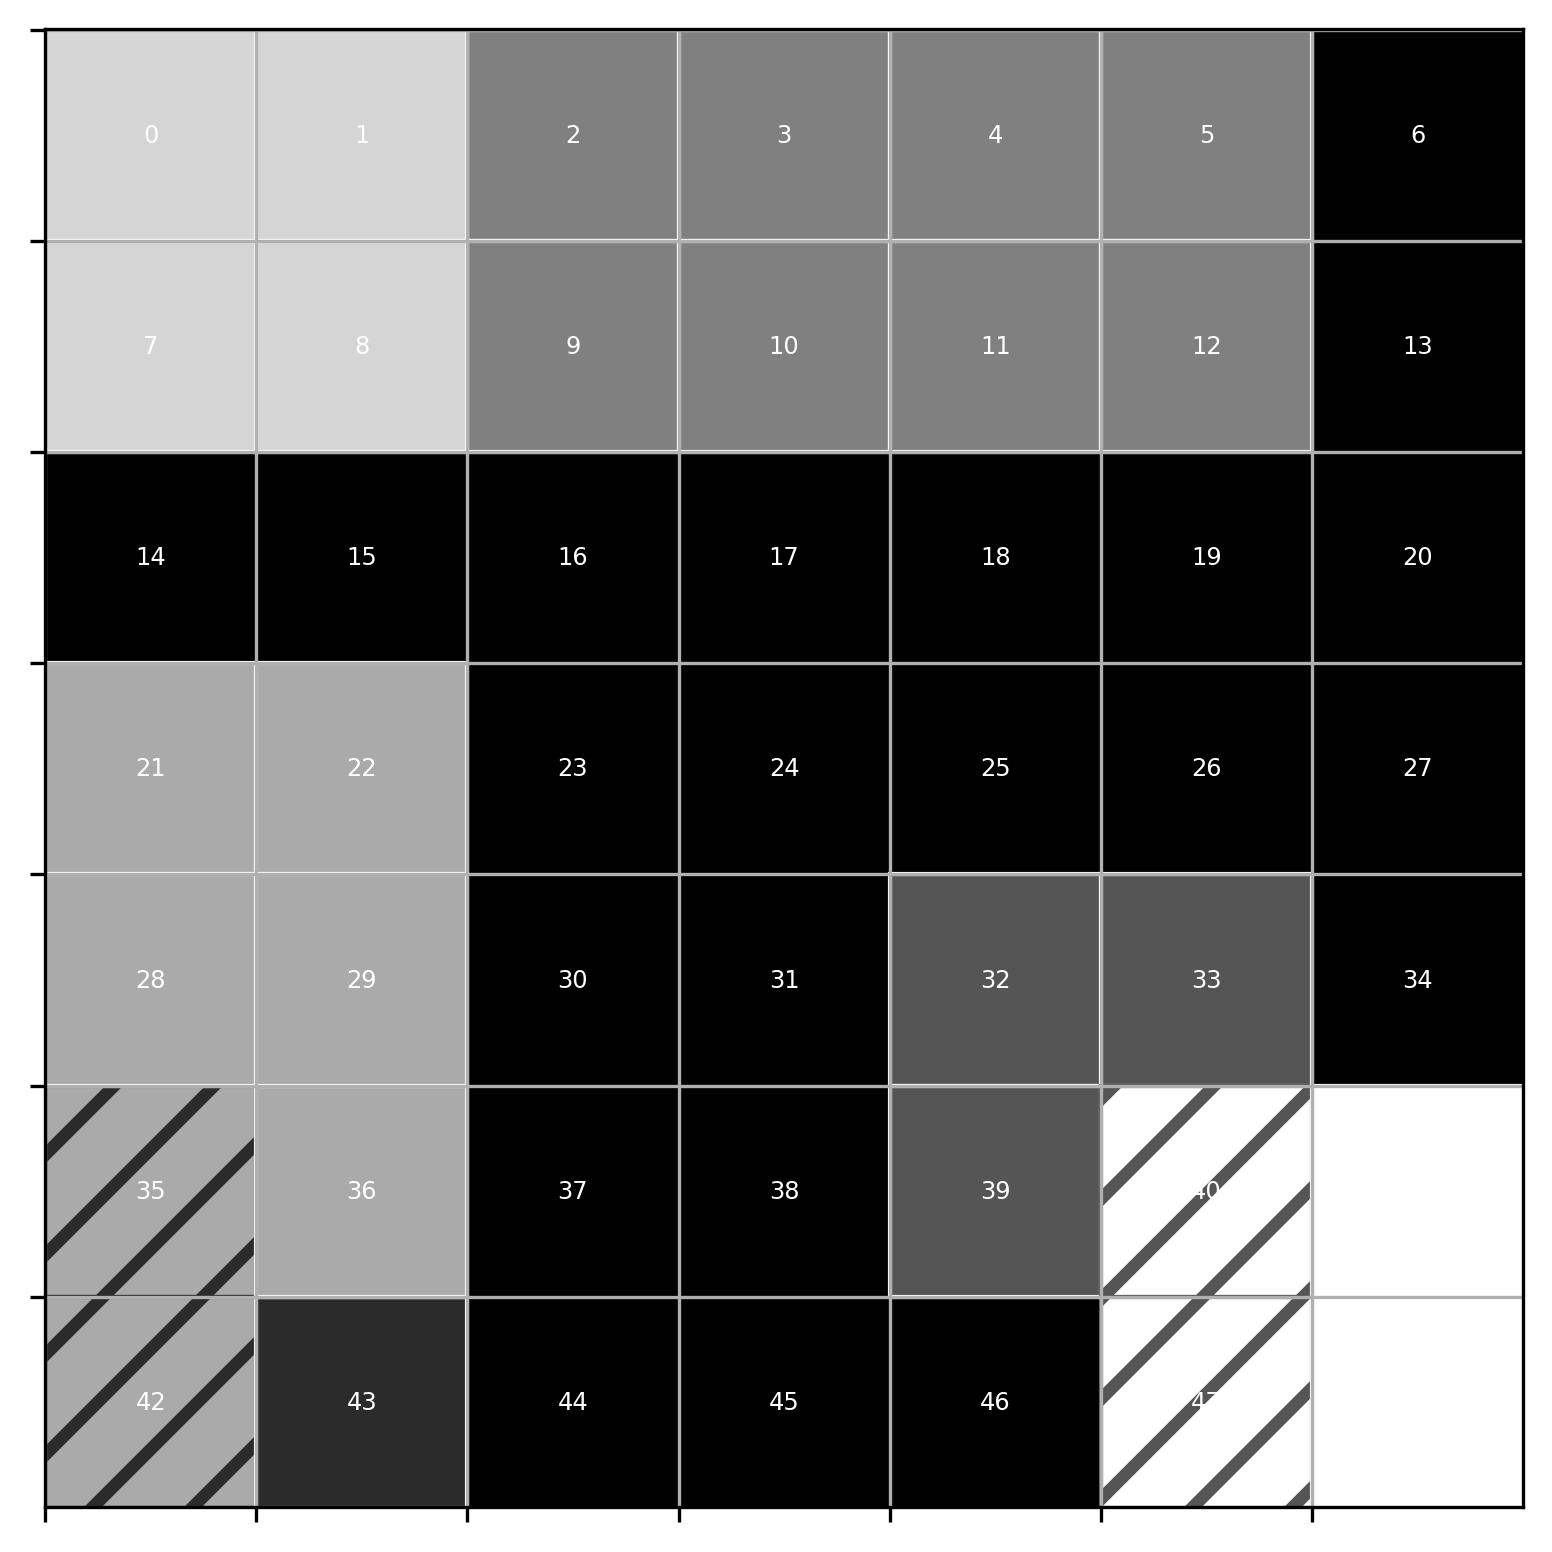

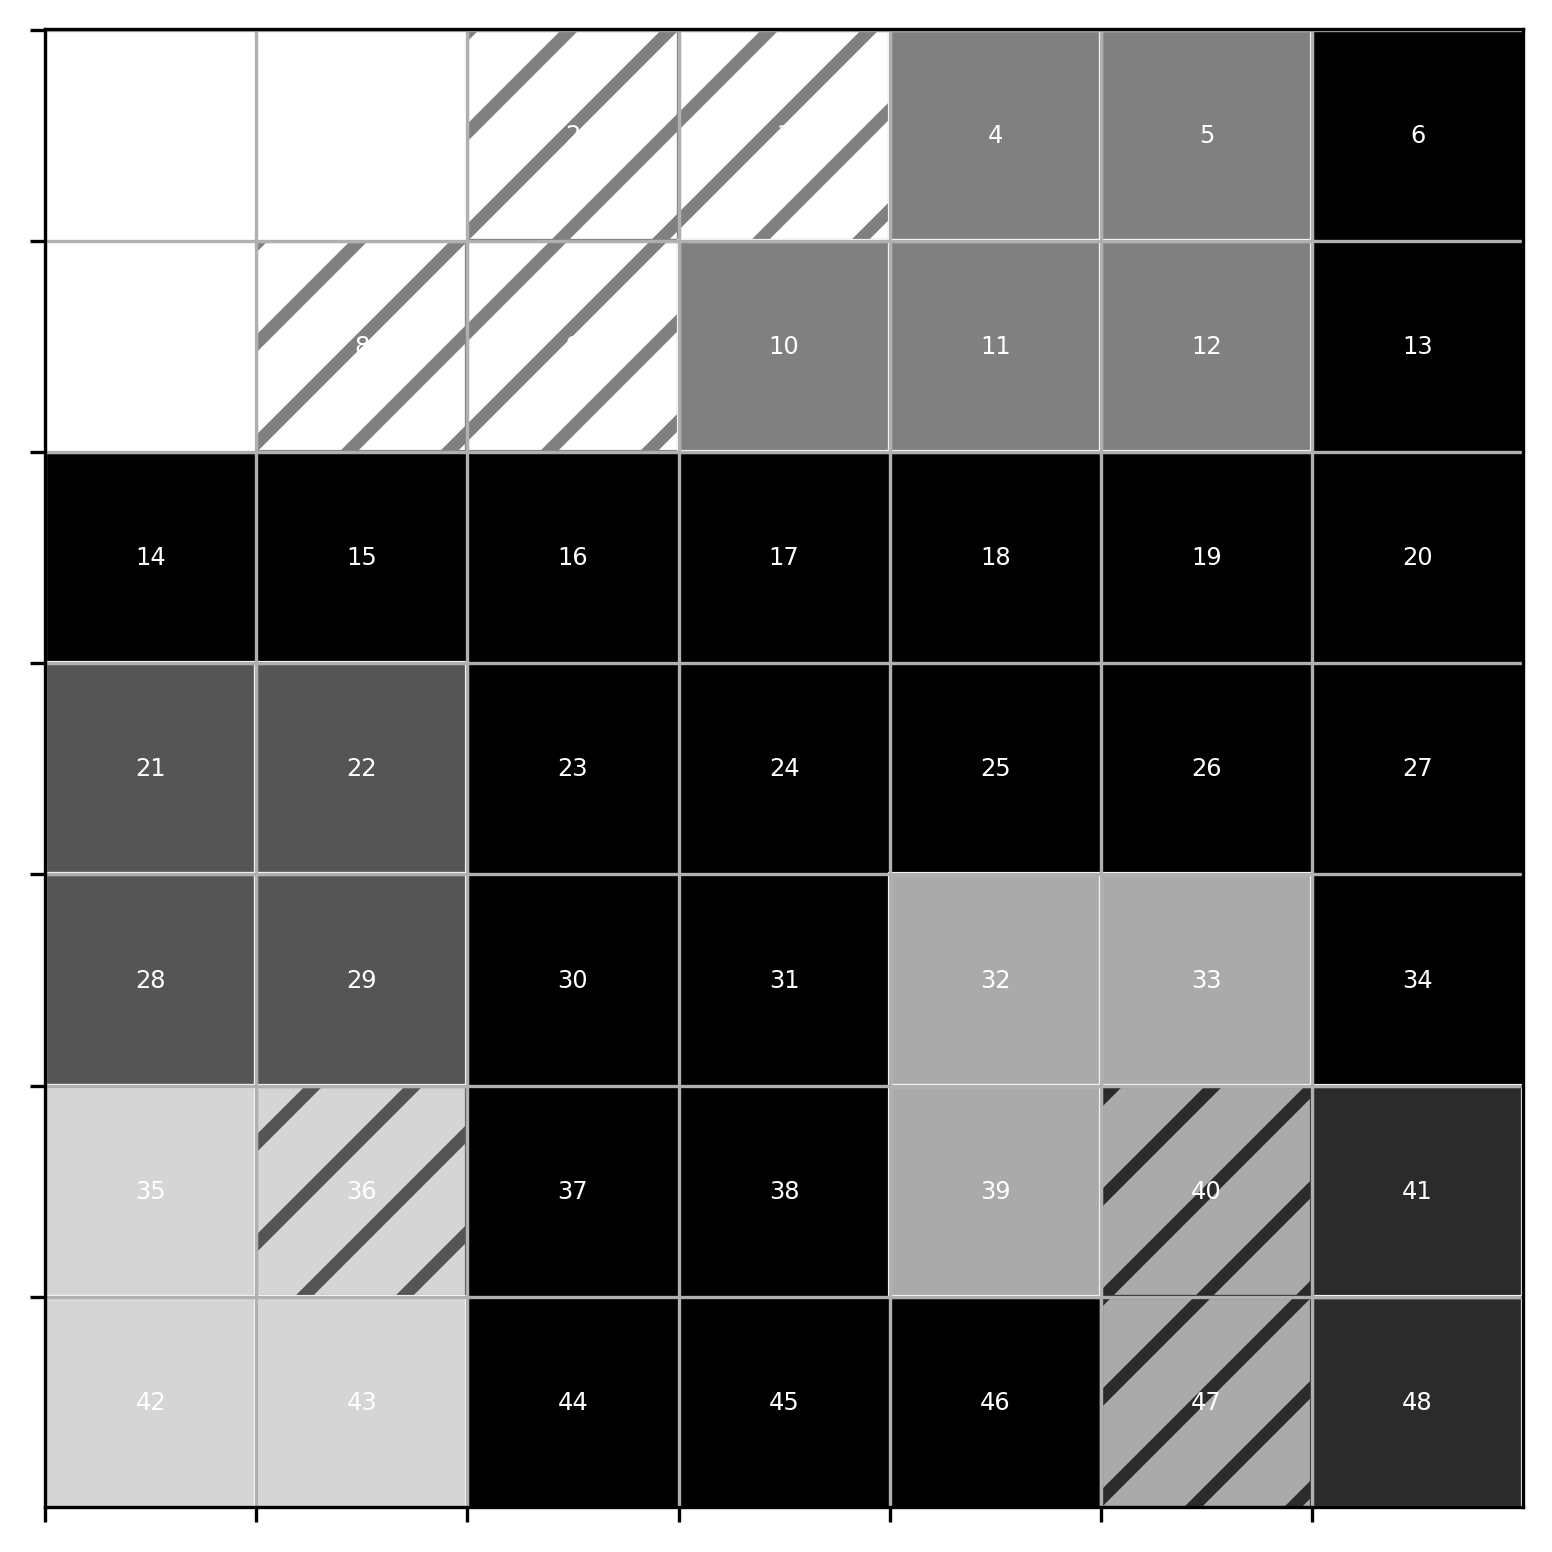

In [33]:
all_object_sets = [{frozenset({36, 21, 22, 28, 29}), frozenset({32, 33, 39, 40, 47}), frozenset({2, 3, 4, 5, 9, 10, 11, 12}), frozenset({43, 42, 35, 36}), frozenset({0, 1, 8, 7}), frozenset({48, 41, 40, 47})}, {frozenset({40, 41, 48, 47}), frozenset({36, 21, 22, 28, 29}), frozenset({32, 33, 39, 40, 47}), frozenset({2, 3, 4, 5, 9, 10, 11, 12}), frozenset({43, 42, 35, 36}), frozenset({0, 1, 2, 3, 7, 8, 9})}, {frozenset({35, 42, 43}), frozenset({40, 41, 48, 47}), frozenset({2, 3, 4, 5, 8, 9, 10, 11, 12}), frozenset({32, 33, 39, 40, 47}), frozenset({35, 36, 21, 22, 42, 28, 29}), frozenset({0, 1, 2, 3, 7, 8, 9})}, {frozenset({32, 33, 48, 39, 40, 41, 47}), frozenset({36, 21, 22, 28, 29}), frozenset({2, 3, 4, 5, 9, 10, 11, 12}), frozenset({43, 42, 35, 36}), frozenset({0, 1, 8, 7})}, {frozenset({35, 42, 43}), frozenset({36, 21, 22, 28, 29}), frozenset({32, 33, 39, 40, 47}), frozenset({2, 3, 4, 5, 9, 10, 11, 12}), frozenset({0, 1, 8, 7}), frozenset({40, 41, 48, 47})}, {frozenset({36, 21, 22, 28, 29}), frozenset({32, 33, 39, 40, 47}), frozenset({2, 3, 4, 5, 9, 10, 11, 12}), frozenset({43, 42, 35, 36}), frozenset({0, 1, 8, 7}), frozenset({40, 41, 48, 47})}, {frozenset({1, 2, 3, 4, 5, 8, 9, 10, 11, 12}), frozenset({35, 42, 43}), frozenset({32, 33, 39, 40, 47}), frozenset({35, 36, 21, 22, 42, 28, 29}), frozenset({0, 1, 8, 7}), frozenset({40, 41, 48, 47})}, {frozenset({36, 21, 22, 28, 29}), frozenset({0, 1, 2, 3, 7, 8, 9}), frozenset({32, 33, 39, 40, 47}), frozenset({2, 3, 4, 5, 9, 10, 11, 12}), frozenset({43, 42, 35, 36}), frozenset({40, 41, 48, 47})}, {frozenset({35, 42, 43}), frozenset({32, 33, 39, 40, 47}), frozenset({2, 3, 4, 5, 9, 10, 11, 12}), frozenset({35, 36, 21, 22, 42, 28, 29}), frozenset({0, 1, 8, 7}), frozenset({40, 41, 48, 47})}, {frozenset({36, 21, 22, 28, 29}), frozenset({2, 3, 4, 5, 8, 9, 10, 11, 12}), frozenset({0, 1, 2, 3, 7, 8, 9}), frozenset({32, 33, 39, 40, 47}), frozenset({43, 42, 35, 36}), frozenset({40, 41, 48, 47})}]

for i, object_sets in enumerate(all_object_sets):
    img_id = 3
    show_objectsets(f"{img_id}.png", "pos", "test", object_sets, i, to_save=True)

(1478, 1478)


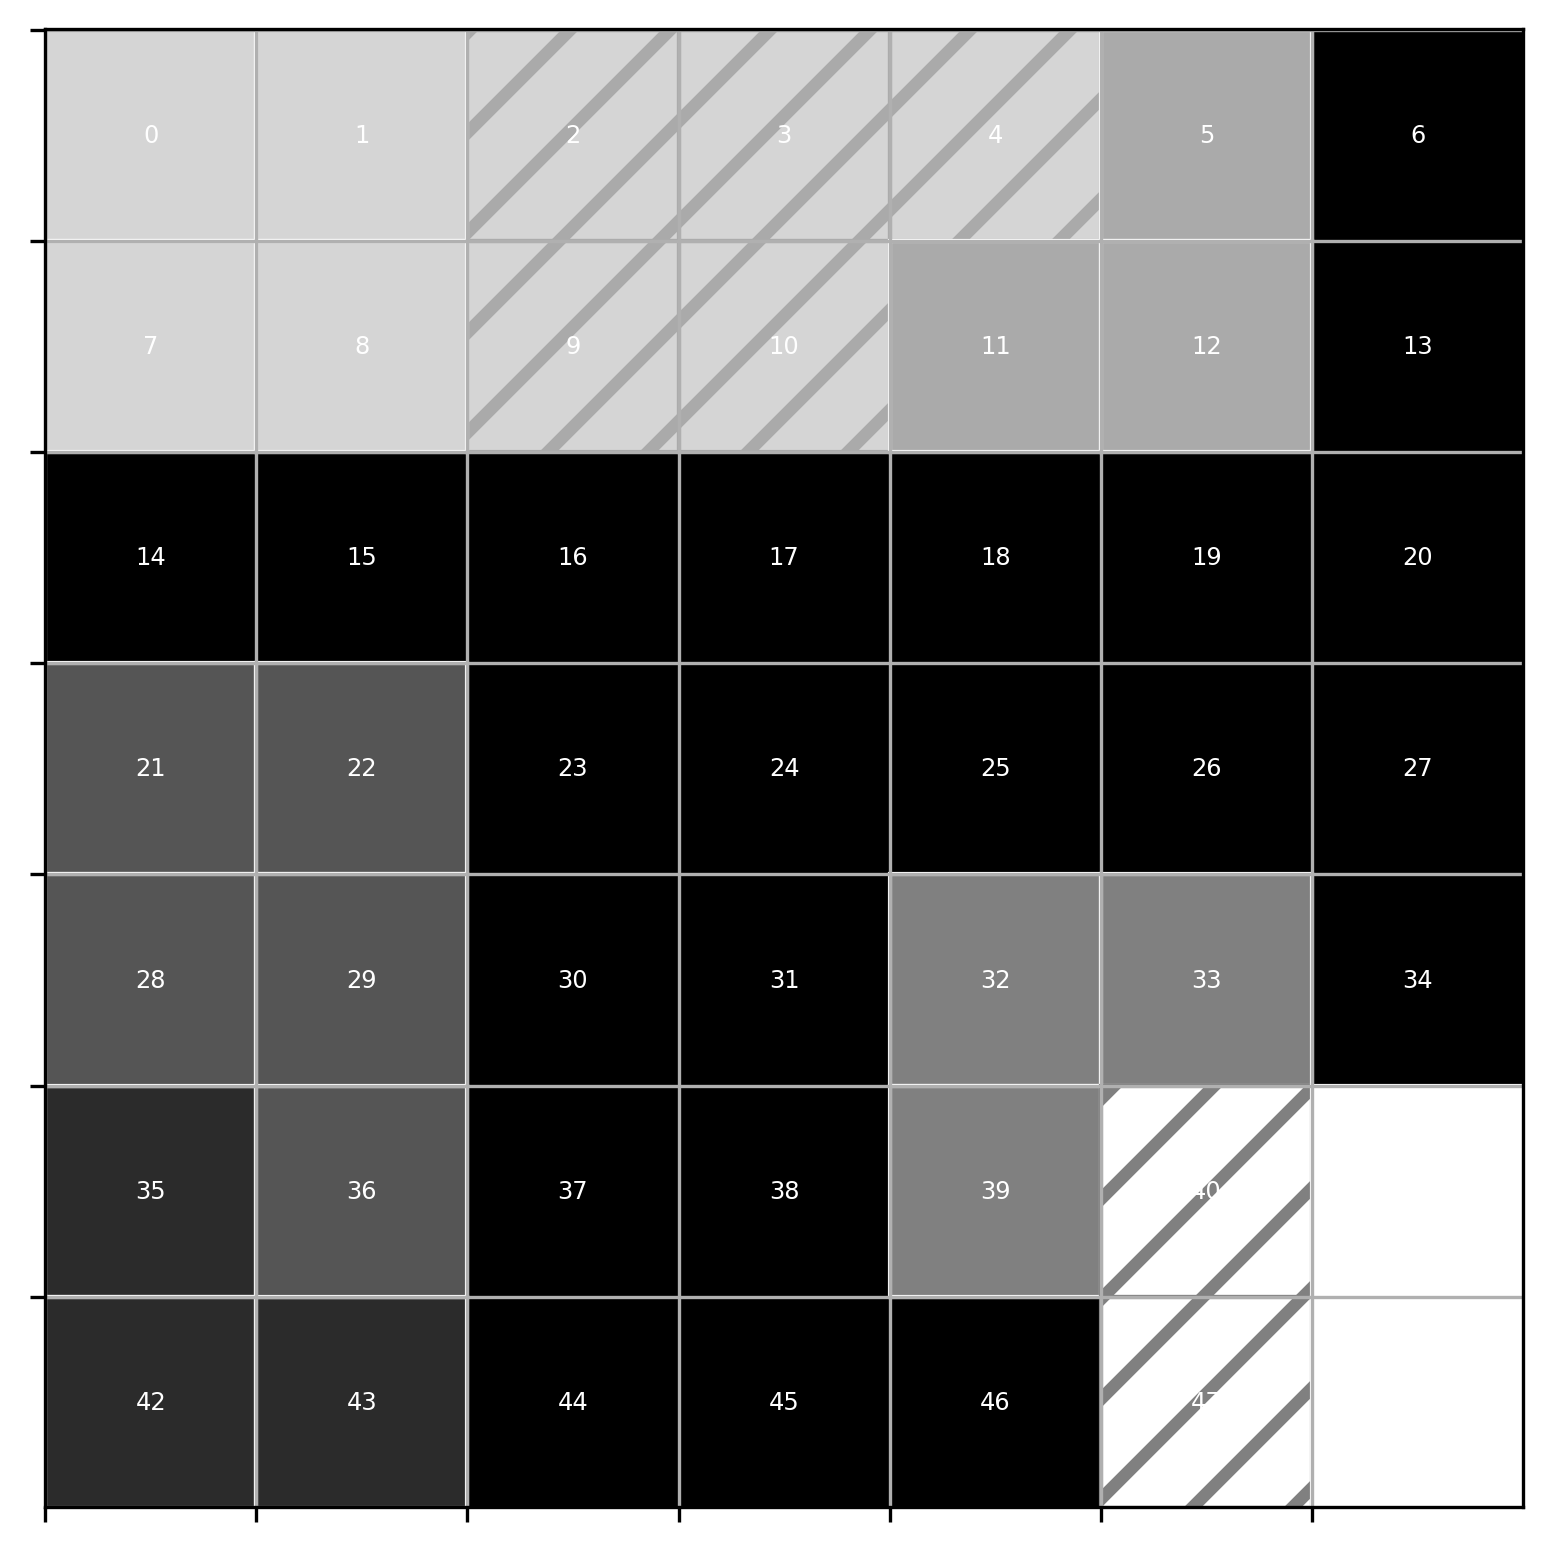

In [29]:
object_sets = {frozenset({35, 42, 43}), frozenset({36, 21, 22, 28, 29}), frozenset({32, 33, 39, 40, 47}), frozenset({2, 3, 4, 5, 9, 10, 11, 12}), frozenset({0, 1, 2, 3, 4, 7, 8, 9, 10}), frozenset({40, 41, 48, 47})}

img_id = 3
show_objectsets(f"{img_id}.png", "pos", "test", object_sets, to_save=False)

(369, 369)


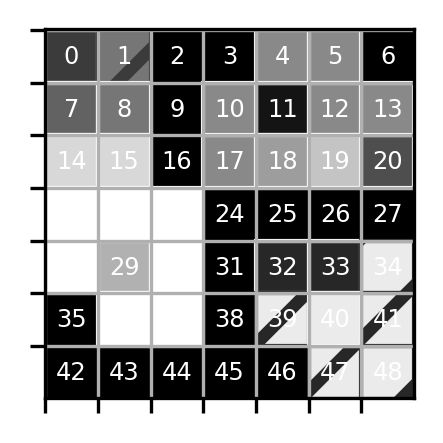

In [23]:
object_sets = {frozenset({11}),
 frozenset({32, 33, 34, 39, 41, 47, 48}),
 frozenset({0, 1}),
 frozenset({20}),
 frozenset({7}),
 frozenset({1, 8}),
 frozenset({4, 5, 10, 12, 13, 17}),
 frozenset({18}),
 frozenset({29}),
 frozenset({19}),
 frozenset({14, 15}),
 frozenset({34, 39, 40, 41, 47, 48}),
 frozenset({21, 22, 23, 28, 30, 36, 37})}

img_id = 3
show_objectsets(f"{img_id}.png", "pos", "test", object_sets, to_save=False)

(369, 369)


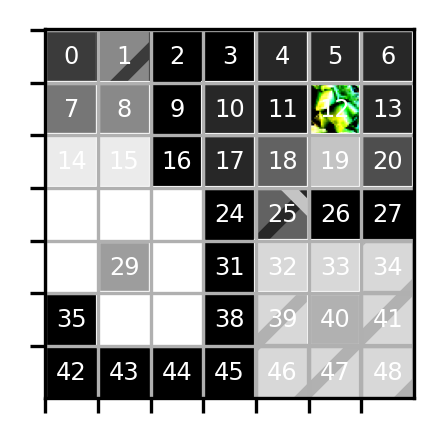

In [24]:
object_sets = {frozenset({11}),
 frozenset({4, 5, 6, 10, 13, 17, 25}),
 frozenset({21, 22, 23, 28, 30, 36, 37}),
 frozenset({0, 1}),
 frozenset({20}),
 frozenset({7}),
 frozenset({1, 8}),
 frozenset({29}),
 frozenset({34, 39, 40, 41, 46, 47, 48}),
 frozenset({19, 25}),
 frozenset({32, 33, 34, 39, 41, 46, 47, 48}),
 frozenset({14, 15}),
 frozenset({18, 25})}

img_id = 3
show_objectsets(f"{img_id}.png", "pos", "test", object_sets, to_save=False)